## Procedure
1. Choose variables. 
2. Analyze each variables and test their causality by Granger causality test.
3. Modify data to obtain stationary 
4. Examine the order and fit the model to the data
5. Split data into test one, and train one. 
6. estimate the period of test data. 
7. Evaluate the model and its estimates. 
8. Retrain the model using all the data and estimate the future. 
9. Test causal inference between variables. 

1. Analyze the time series characteristics
2. Test for causation amongst the time series
3. Test for stationarity
4. Transform the series to make it stationary, if needed
5. Find optimal order (p)
6. Prepare training and test datasets
7. Train the model
8. Roll back the transformations, if any.
9. Evaluate the model using test set
10. Forecast to future

## Variables to use 
 
1. Industrial Production Index (IPI)
2. the ratio of trade to GDP (TRADE)
3. the ratio of government final consumption expenditure (GCE)
4. Bank credit to private sector (BCP)
5. the ration of private sector's domestic credit to GDP (GDPP)
6. the ratio of M3 to GDP (GDPM)
7. the ratio of domestic savings to GDP (GDS)
8. interest rates New!
9. turnover ratio
10. the ratio of stock market total value traded to GDP (SMT)


World Bank Indicator
https://databank.worldbank.org/source/world-development-indicators#

入手できた変数
Domestic credit to private sector,
GDP growth,General government final consumption expenditure (% of GDP)
GCE, Gross domestic savings (% of GDP) GCS,
Domestic credit to private sector (% of GDP)→GDPP,
Stocks traded, total value (% of GDP)→SMT,
Trade (% of GDP),
Real interest rate (%)→RIR,
Deposit interest rate (%),
Domestic credit to private sector by banks (% of GDP)→BCP,
Broad money (% of GDP) instead of GCPM
turnover ratio：stocks traded, turnover ratio of domestic shares(%)
broad moneyへの変更などが特記事項．これは論文も変える必要がある．
## Database to check



FREDMD:id 80 : S&P 500, id 71 M2 Money stock, 
Kaggle: IPI
World Bank WDI databaseーfinancial development：BCP, GDPP, GDS 年次
World Bank WDI databaseーfinancial development, stock market development：


World Bank WDI databaseからfinancial development, stock market development, real sector and economic growthなどもデータ入手先の候補
データソースは International Financial Statistics, South Africa Reserve Bank, Johannesburg Stock Exchange　ーUmar

In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error , mean_absolute_error
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw,pacf_ols
#ARモデル
from statsmodels.tsa.ar_model import AR,ARResults
#ARIMAモデル
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from pandas.plotting import lag_plot
import math
from statsmodels.stats.stattools import durbin_watson
# Ignore harmless warning
import warnings
warnings.filterwarnings("ignore")

In [47]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series, title = ""):
    """
    時系列を投入し，オプションでタイトルを決めると，ADFレポートを返す
    """
    print(f"Augumented Dickey-Fuller Test:{title}")
    result = adfuller(series.dropna(),autolag = "AIC") # .dropna() handles differenced data
    labels = ["ADS test statistic", "p-value", "# lags used", "# observations"] # # はnumberの略
    out = pd.Series(result[0:4],index = labels)

    for key, val in result[4].items():
        out[f"Critical Value ({key})"] = val
    print(out.to_string()) # .to_string() は "dtype:float64"を取り除く

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    return result[1]

#ここからadfなどもして前期との相関を見てくれる関数を作る
def plot_series(series, figsize = (9,6), title = "", model = "add"):
    season = seasonal_decompose(series,model = model)
    season.plot();

def plot_property(series, title = "", num = 30):
    lag_plot(series)
    plot_acf(series,lags = num, title = f"{title} ACF")
    plot_pacf(series,lags = num,title = f"{title} PACF")


def all_plot(data, title = "", figsize = (12,9),model = "add",series = False, acf = False ,num = 30,col = 2):
    """
    全てのデータをプロットする．オプションでacf, pacfもプロットできるはず
    """
    columns = data.columns
    fig, axes = plt.subplots(nrows= math.ceil(len(columns)/col), ncols=col, dpi=120, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i <= len(columns)-1:
            df = data[data.columns[i]]
            ax.plot(df, linewidth=1)
            ax.set_title(data.columns[i])
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')
            ax.spines["top"].set_alpha(0)
            ax.tick_params(labelsize=6)
            plt.subplots_adjust(hspace=0.6)
    for column in columns:
        if series == True:
            plot_series(data[column],title = column, model = model,figsize = figsize)
        if acf == True:
            plot_property(data[column], title = column, num = num)

#何個のdiffを取るべきかを明らかにする
def auto_adf(data):
    num = len(data.columns)
    #num_dic shows how many times the series need to be differenced
    num_dic = {}
    for x in range(num):
        result = adf_test(data.iloc[:,x])
        diff_num = 0
        series = data.iloc[:,x].diff()
        while result > 0.05:
            result = adf_test(series)
            series = series.diff()
            diff_num = diff_num + 1
        print(f"{data.columns[x]} needs {diff_num} times difference to obtain stationary")
        num_dic[data.columns[x]] = diff_num
        print("--------------------------------")
    return num_dic

#diffを行う回数分差分を取り，それを再びデータとして加える．
def differencing_data(data):
    #make a new data frame, which requires the same index of the original data
    idx = pd.date_range(data.index[0],periods = len(data.index),freq = data.index.freq)
    new_data = pd.DataFrame(index = idx)
    #辞書型のデータを取る
    dic_data = auto_adf(data)
    num = len(data.columns)
    for x in range(num):
        series = data.iloc[:,x]
        diff_num = dic_data[data.columns[x]]
        diff_times = 0
        while diff_times != diff_num:
            series = series.diff()
            diff_times = diff_times + 1
        #add series to the new_data
        new_data[f"{data.columns[x]}_{diff_num}"] = series
    return new_data.dropna()


#予測の関数を作る,　蜜柑

def ARforecast(original_data,num = 5,order = 6):
    """
    You need to input stationary data.
    The function automatically forecast with AR model.
    You can input DataFrame.
    The function returns the forecasts of variables and their lags in AR models as a dictionary.
    """
    data = differencing_data(original_data).dropna()
    train = data[:-num]
    test = data[-num:]    
    lags = {}
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(index = idx,columns = data.columns)
    for key in data.columns:
        result_AIC = {}
        result_BIC = {}
        for i in range(1,order):
            model = AR(train[[key]])
            result = model.fit(i)
            result_AIC[i] = result.aic
            result_BIC[i] = result.bic
        min_AIC = min(result_AIC, key=result_AIC.get)
        min_BIC = min(result_BIC, key = result_BIC.get)
        md = AR(train[key])
        result = md.fit(min_AIC)
        print(result.summary())
        lag_order = result.k_ar
        lags[key] = lag_order
        start = len(train)
        end = len(train) + len(test) - 1
        forecast = result.predict(start = start ,end = end)
        idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
        df_forecast[key] = pd.DataFrame(forecast)
    return df_forecast,lags # return is two variables

#VARforecast関数に投入するtrainデータにはnot positive definiteの列を加えてはならない
#------Q. not positive definiteとなる列をどのように処理するのか？？--------
def VARforecast(data,num = 5,order = 7,orth = True):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order+3)
    irf.plot(orth=orth)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    # Durbin_watsonを組み込んだ
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("Durbin Watson Test is ended")
    return df_forecast.dropna()

#granger causalityを調べる関数が必要である．
# original data でgrnger causalityを調べたとして，それはdifferenced dataに対しても有効になるのか？
maxlag=10
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test',set_p_value =0.05, verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            #p_values = [test_result[i+1][0][test][1] for i in range(maxlag)]
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            if min_p_value < set_p_value or min_p_value == 1:
                df.loc[r, c] = min_p_value
            else:
                df.loc[r, c] = False
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#共和分のテスト
def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary_
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


#二つのデータをプロットして比較してくれる関数
def compare_plot(series1,series2,size = (12,6),title1 = "", title2 = "", legend = True, tight = True):
    """
    二つのデータを同時にプロット
    Plot two data simultaneously
    """
    ax = series1.plot(figsize = size, legend = legend, title = title1)
    ax.autoscale(axis = "x", tight = tight)
    dx = series2.plot(figsize = size, legend = legend, title = title1)
    dx.autoscale(axis = "x", tight = tight)

#基のデータに戻していくプロセスを行う
def reverse_data(original_data, num = 5, order = 7,orth=True):
    """
    VARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast = VARforecast(original_data,num = num,order = order,orth=orth)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        elif diff_time ==2:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
        elif diff_time == 3:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - 2*original_data[column[:-2]].iloc[-num-2] + original_data[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
            diff_data[f"{column}_reversed_2"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
        if column[:12] == "S_P500(log%)":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
    return new_data.dropna()

def ar_reverse_data(original_data, num = 5, order = 7):
    """
    ARforecastを利用して，定常な時系列の予測値をだし，その予測値を基のデータに戻していく．
    """
    df_forecast,lags = ARforecast(original_data,num = num,order = order)
    idx = pd.date_range(df_forecast.index[0],periods = len(df_forecast),freq = df_forecast.index.freq)
    new_data = pd.DataFrame(index = idx)
    diff_data = pd.DataFrame(index = idx)
    columns = df_forecast.columns
    for column in columns:
        diff_time = int(column[-1])
        if diff_time == 0:
            new_data[f"{column}_reversed_{diff_time}"] = df_forecast[column]
        elif diff_time == 1:
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
        elif diff_time ==2:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + df_forecast[column].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_1"].cumsum()
        elif diff_time == 3:
            diff_data[f"{column}_reversed_1"] = original_data[column[:-2]].iloc[-num-1] - 2*original_data[column[:-2]].iloc[-num-2] + original_data[column[:-2]].iloc[-num-3] + df_forecast[column].cumsum()
            diff_data[f"{column}_reversed_2"] = original_data[column[:-2]].iloc[-num-1] - original_data[column[:-2]].iloc[-num-2] + diff_data[f"{column}_reversed_1"].cumsum()
            new_data[f"{column}_reversed_{diff_time}"] = original_data[column[:-2]].iloc[-num-1] + diff_data[f"{column}_reversed_2"].cumsum()
        else:
            print(f"{column} needs differenced more than 3 times, so this {column} should be further considered")
        if column[:12] == "S_P500(log%)":
            diff_data[column] = original_data[column[:-2]].iloc[-num-1] + df_forecast[column].cumsum()
            new_data[column] = diff_data[column].apply(math.exp)
    return new_data.dropna(),lags

def VAR_AR_plot_evaluation(data,col = 2,num = 5,order = 7,orth= True):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse_vr = reverse_data(data, num = num,order = order,orth = orth)
    print("reverse_data is executed")
    reverse_ar,lag = ar_reverse_data(data,num = num, order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse_vr[reverse_vr.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        reverse_ar[reverse_ar.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} VAR Forecast",f"{col} AR Forecast",f"{col} Actual"])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    for i in range(len(data.columns)):
        accuracy_prod_vr = forecast_accuracy(reverse_vr[reverse_vr.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} VAR Accuracy")
        for k, v in accuracy_prod_vr.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        accuracy_prod_ar = forecast_accuracy(reverse_ar[reverse_ar.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} AR Accuracy")
        for k, v in accuracy_prod_ar.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    print(f"AR lag is {lag}")
    return lag

#プロットして比較する．
def FvsA_plot(data,col = 2,num = 5,order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    """
    reverse = reverse_data(data, num = num,order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)

# Evaluate関数
#予測するための道具を出す．
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'mean':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def forecast_data(data,col = 2, num = 5, order = 7):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較してプロットする．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = reverse_data(data,num = num,order=order)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")

def Durbin_Watson(data,num = 5,order = 7):
    """
    Durbin_Watson検定を行う．その際には，differencingしたデータでmin AICとなるモデルを選択して当てはめる．
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった
    """
    use_data= differencing_data(data).dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    
        
## Durbing Watsonの関数を作る
# model = VAR(df_differenced)
# model_fitted = model.fit(4)
# out = durbin_watson(model_fitted.resid)
# for col, val in zip(df.columns, out):
#     print(adjust(col), ':', round(val, 2))

In [6]:
# differencingしないパターンでの関数を作成した
# nodiffではreverseも必要ない
def VARforecast_nodiff(data,num = 5,order = 7,orth= True):
    """
    ここではVARforecastを抽出するが，not positive definiteとなるような列は除く必要がある．
    実際に，USAではRIR_1と，Turnover_Ratio_1を除かなければならなかった．
    """
    use_data= data.dropna()
    train = use_data[:-num]
    test = use_data[-num:]
    result_AIC = {}
    result_BIC = {}
    for i in range(order):
    #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
        model = VAR(train)
        result = model.fit(i)
        result_AIC[i] = result.aic
        result_BIC[i] = result.bic
    min_AIC = min(result_AIC, key=result_AIC.get)
    min_BIC = min(result_BIC, key = result_BIC.get)
    result = model.fit(min_AIC)
    lag_order = result.k_ar
    print("------------------------")
    print(result.summary())
    print("------------------------")
    irf = result.irf(order)
    irf.plot(orth=orth)
    plt.show()
    print("The function plots the Forecast Error Variance Decomposition")
    result.fevd(num).summary()
    result.fevd(num).plot()
    forecast = result.forecast(y=train.values[-lag_order:],steps = num)
    idx = pd.date_range(test.index[0],periods = num, freq = data.index.freq)
    df_forecast = pd.DataFrame(forecast, index = idx, columns = test.columns)
    print("Durbin Watson test is executed")
    out = durbin_watson(result.resid)
    def adjust(val, length= 6): return str(val).ljust(length)
    for col, val in zip(use_data.columns, out):
        print(adjust(col), ':', round(val, 2))
    print("Durbin Watson test is ended")
    print("-------------------------------")
    return df_forecast

def VAR_AR_plot_evaluation_nodiff(data,col = 2,num = 5,order = 7,orth=True):
    """
    VARforecast_nodiffで帰ってきた予測値と，実際のデータとを比較してプロットする．
    reverse_dataの代わりにVARforecast_nodiffを利用
    reverse_dataで帰ってきた予測値と，実際のデータとを比較する．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse_vr = VARforecast_nodiff(data, num = num,order = order,orth=orth)
    print("reverse_data is executed")
    reverse_ar,lag = ar_reverse_data(data,num = num, order = order)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(data.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse_vr[reverse_vr.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        reverse_ar[reverse_ar.columns[i]].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
        test[col][-num:].plot(legend=True, ax=ax);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} VAR Forecast",f"{col} AR Forecast",f"{col} Actual"])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)
    for i in range(len(data.columns)):
        accuracy_prod_vr = forecast_accuracy(reverse_vr[reverse_vr.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} VAR Accuracy")
        for k, v in accuracy_prod_vr.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        accuracy_prod_ar = forecast_accuracy(reverse_ar[reverse_ar.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]} AR Accuracy")
        for k, v in accuracy_prod_ar.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
    print(f"AR lag is {lag}")
    #return lag

def FvsA_plot_nodiff(data,col = 2,num = 5):
    """
    VARforecast_nodiffで帰ってきた予測値と，実際のデータとを比較してプロットする．
    reverse_dataの代わりにVARforecast_nodiffを利用
    """
    reverse = VARforecast_nodiff(data, num = num)
    test = data.dropna()[-num:]
    fig, axes = plt.subplots(nrows= math.ceil(len(reverse.columns)/col), ncols= col, dpi=150, figsize=(10,10))
    for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
        reverse[reverse.columns[i]].plot(legend=True, ax=ax)
        test[col][-num:].plot(legend= True, ax=ax).autoscale(axis='x',tight=True);
        ax.set_title(col + ": Forecast vs Actuals")
        ax.legend([f"{col} Forecast",f"{col} Actual"])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=0.3)
        plt.subplots_adjust(hspace=0.6)


def forecast_data_nodiff(data,col = 2, num = 5):
    """
    reverse_dataで帰ってきた予測値と，実際のデータとを比較する．
    その際に，forecast_accuracy関数を利用する．
    numは予測する数
    """
    reverse = VARforecast_nodiff(data,num = num,)
    test = data.dropna()[-num:]
    for i in range(num):
        accuracy_prod = forecast_accuracy(reverse[reverse.columns[i]].values,test[test.columns[i]])#valueはなくていいのか？
        print(f"{test.columns[i]}")
        for k, v in accuracy_prod.items():
            print(f"{k} : {round(v,4)}")
        print("----------------------------")
        
# no_diffの場合
# def Durbin_Watson_nodiff(data,num = 5,order = 7):
#     """
#     ダービンワトソン検定をdifferencingなしで行う．
#     """
#     use_data= data.dropna()
#     train = use_data[:-num]
#     test = use_data[-num:]
#     result_AIC = {}
#     result_BIC = {}
#     for i in range(order):
#     #この，VARの作り方が悪いかもしれない．外生変数とない性変数をうまく区別できていないのではないだろうか
#         model = VAR(train)
#         result = model.fit(i)
#         result_AIC[i] = result.aic
#         result_BIC[i] = result.bic
#     min_AIC = min(result_AIC, key=result_AIC.get)
#     min_BIC = min(result_BIC, key = result_BIC.get)
#     result = model.fit(min_AIC)
#     out = durbin_watson(result.resid)
#     def adjust(val, length= 6): return str(val).ljust(length)
#     for col, val in zip(use_data.columns, out):
#         print(adjust(col), ':', round(val, 2))
# Durbin_Watson_nodiff(USA.drop("GCE",axis = 1).drop("RIR",axis = 1).drop("Turnover_Ratio",axis = 1).drop("TRADE",axis = 1).drop("Broad_money",axis = 1).drop("BCP",axis = 1))
# Durbin_Watson_nodiff(USA.drop("GCE",axis = 1).drop("RIR",axis = 1).drop("Turnover_Ratio",axis = 1).drop("TRADE",axis = 1).drop("Broad_money",axis = 1).drop("BCP",axis = 1))

In [24]:
USA = pd.read_csv("/Users/takahiro/Desktop/Final Project/Data_Sets/America/FYP_USA.csv",index_col= 0,header = 0, parse_dates = True)
USA.index.freq = "YS"
print(USA.columns)
USA["Working_People(%)"] = USA["Working_People(million)"].dropna().pct_change()
USA["S_P500(log%)"] = USA["S_P500"].apply(np.log).diff()
df_usa = differencing_data(USA.dropna())
adf_test(USA["S_P500(log%)"])

Index(['S_P500', 'GDP_growth', 'GCE', 'GDS', 'GDPP', 'SMT', 'TRADE', 'RIR',
       'BCP', 'Turnover_Ratio', 'Broad_money', 'population(15-64,milion)',
       'Unemployment(%)', 'Working_People(million)'],
      dtype='object')
Augumented Dickey-Fuller Test:
ADS test statistic       1.067086
p-value                  0.994926
# lags used              0.000000
# observations          34.000000
Critical Value (1%)     -3.639224
Critical Value (5%)     -2.951230
Critical Value (10%)    -2.614447
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -4.100322
p-value                  0.000967
# lags used              0.000000
# observations          33.000000
Critical Value (1%)     -3.646135
Critical Value (5%)     -2.954127
Critical Value (10%)    -2.615968
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
S_P5

1.4084861444739921e-11

In [18]:
USA.drop("RIR",axis = 1).drop("SMT",axis = 1).drop("Turnover_Ratio",axis=1).dropna()
grangers_causation_matrix(df_usa.dropna(),variables=df_usa.columns)

S_P500_1_x  GDP_growth_0_x  GCE_0_x  GDS_2_x  \
S_P500_1_y                           1.0             0.0      0.0   0.0000   
GDP_growth_0_y                       0.0             1.0      0.0   0.0000   
GCE_0_y                              0.0             0.0      1.0   0.0000   
GDS_2_y                              0.0             0.0      0.0   1.0000   
GDPP_3_y                             0.0             0.0      0.0   0.0000   
SMT_1_y                              0.0             0.0      0.0   0.0000   
TRADE_1_y                            0.0             0.0      0.0   0.0000   
RIR_1_y                              0.0             0.0      0.0   0.0001   
BCP_0_y                              0.0             0.0      0.0   0.0000   
Turnover_Ratio_1_y                   0.0             0.0      0.0   0.0000   
Broad_money_1_y                      0.0             0.0      0.0   0.0000   
population(15-64,milion)_0_y         0.0             0.0      0.0   0.0000   
Unemployment(%)_0_y                  0.0             0.0      0.0   0.0000   
Working_People(million)_1_y          0.0             0.0      0.0   0.0000   
Working_People(%)_0_y                0.0             0.0      0.0   0.0000   
S_P500(log%)_0_y                     0.0             0.0      0.0   0.0000   

                              GDPP_3_x  SMT_1_x  TRADE_1_x  RIR_1_x  BCP_0_x  \
S_P500_1_y                         0.0      0.0        0.0   0.0000      0.0   
GDP_growth_0_y                     0.0      0.0        0.0   0.0000      0.0   
GCE_0_y                            0.0      0.0        0.0   0.0000      0.0   
GDS_2_y                            0.0      0.0        0.0   0.0000      0.0   
GDPP_3_y                           1.0      0.0        0.0   0.0000      0.0   
SMT_1_y                            0.0      1.0        0.0   0.0000      0.0   
TRADE_1_y                          0.0      0.0        1.0   0.0000      0.0   
RIR_1_y                            0.0      0.0        0.0   1.0000      0.0   
BCP_0_y                            0.0      0.0        0.0   0.0000      1.0   
Turnover_Ratio_1_y                 0.0      0.0        0.0   0.0000      0.0   
Broad_money_1_y                    0.0      0.0        0.0   0.0000      0.0   
population(15-64,milion)_0_y       0.0      0.0        0.0   0.0000      0.0   
Unemployment(%)_0_y                0.0      0.0        0.0   0.0000      0.0   
Working_People(million)_1_y        0.0      0.0        0.0   0.0018      0.0   
Working_People(%)_0_y              0.0      0.0        0.0   0.0000      0.0   
S_P500(log%)_0_y                   0.0      0.0        0.0   0.0000      0.0   

                              Turnover_Ratio_1_x  Broad_money_1_x  \
S_P500_1_y                                0.0000              0.0   
GDP_growth_0_y                            0.0000              0.0   
GCE_0_y                                   0.0000              0.0   
GDS_2_y                                   0.0000              0.0   
GDPP_3_y                                  0.0000              0.0   
SMT_1_y                                   0.0000              0.0   
TRADE_1_y                                 0.0000              0.0   
RIR_1_y                                   0.0000              0.0   
BCP_0_y                                   0.0000              0.0   
Turnover_Ratio_1_y                        1.0000              0.0   
Broad_money_1_y                           0.0000              1.0   
population(15-64,milion)_0_y              0.0006              0.0   
Unemployment(%)_0_y                       0.0000              0.0   
Working_People(million)_1_y               0.0000              0.0   
Working_People(%)_0_y                     0.0000              0.0   
S_P500(log%)_0_y                          0.0000              0.0   

                              population(15-64,milion)_0_x  \
S_P500_1_y                                             0.0   
GDP_growth_0_y                              

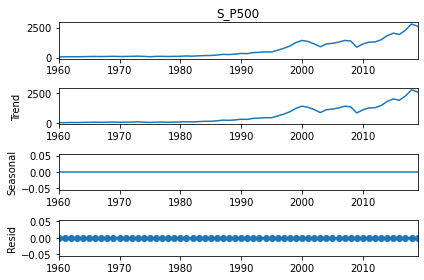

In [6]:
plot_series(USA)

In [16]:
# data=  USA.drop("GCE",axis = 1).drop("TRADE",axis = 1).drop("Turnover_Ratio",axis = 1).dropna()
# reverse = reverse_data(data,num=5,order= 5)
# print(reverse)
# test = data.dropna()[-5:]
# combine = pd.concat([reverse['S_P500_1_reversed_1'], test['S_P500']], axis=1)
# combine['accuracy'] = round(combine.apply(lambda row: row.S_P500_1_reversed_1 /row.S_P500 *100, axis = 1),2)
# print(combine.index)
# combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index,parse_date = True)
# combine = combine.round(decimals=2)
# combine = combine.reset_index()
# combine = combine.sort_values(by='Date', ascending=False)

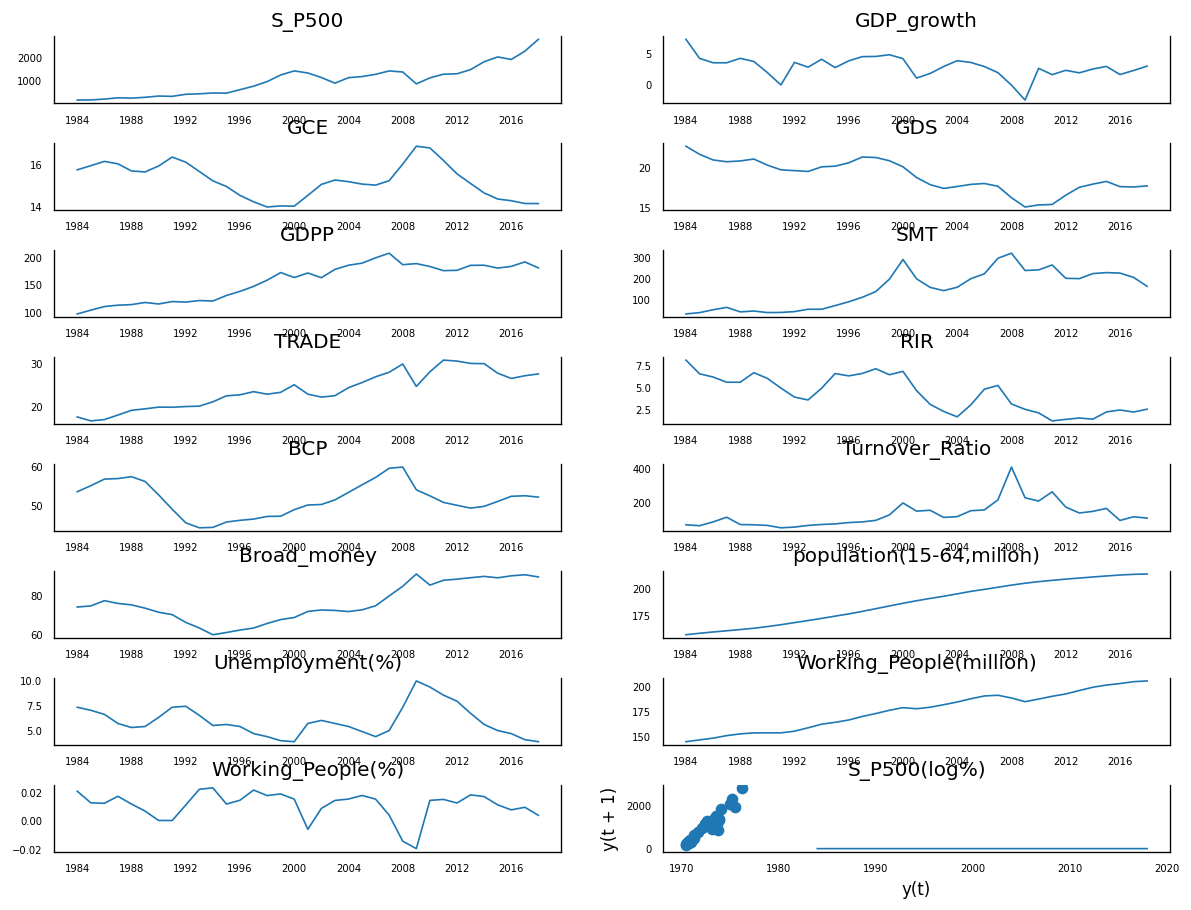

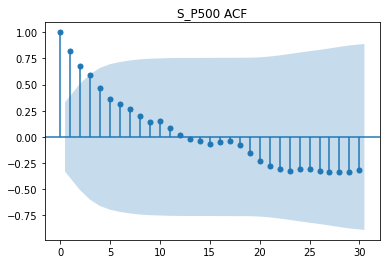

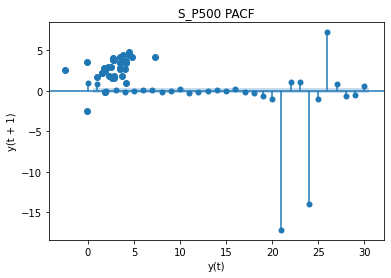

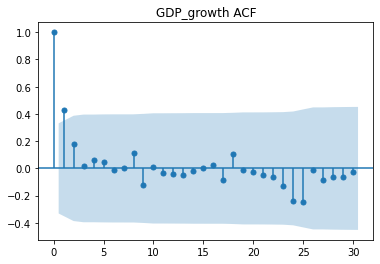

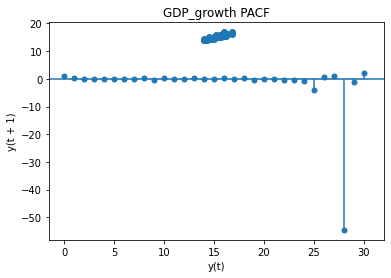

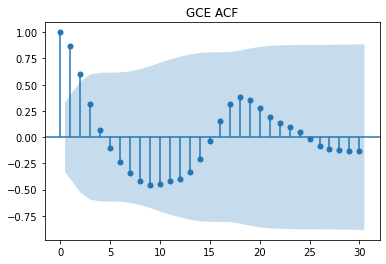

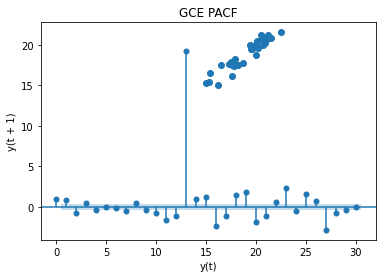

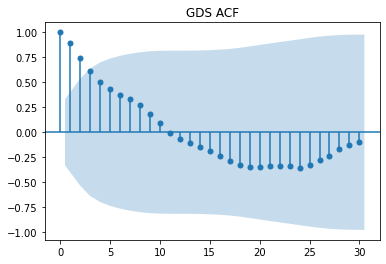

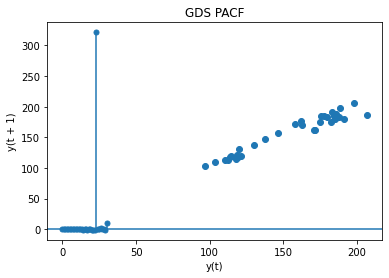

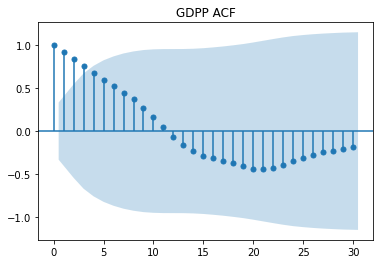

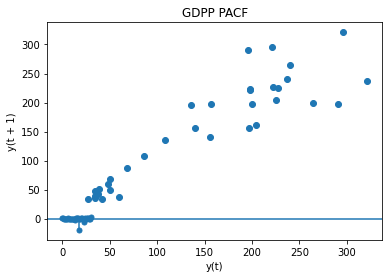

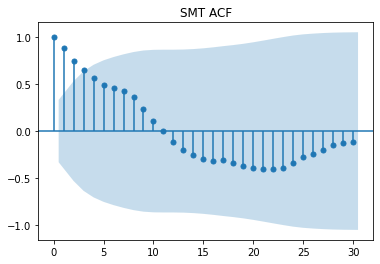

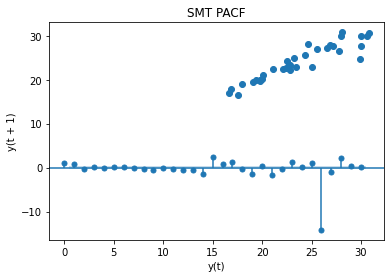

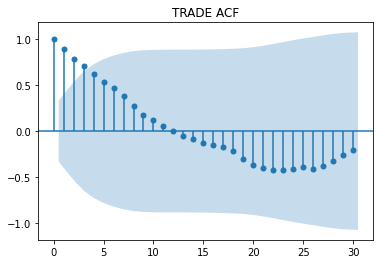

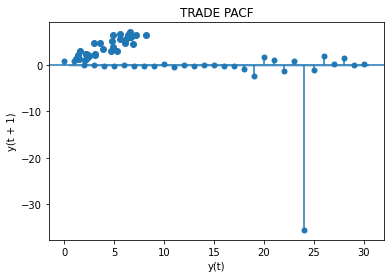

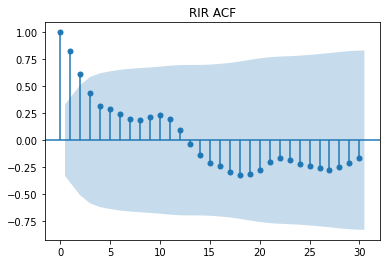

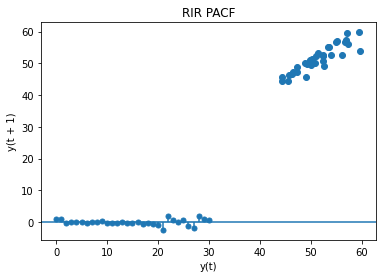

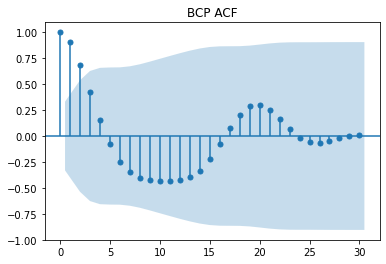

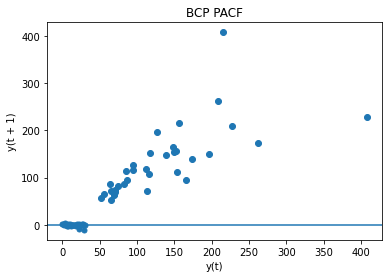

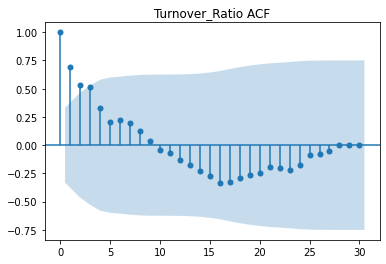

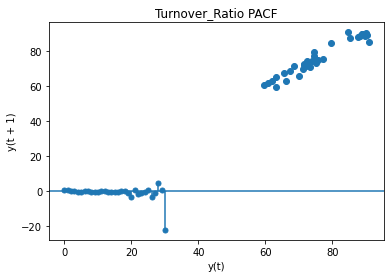

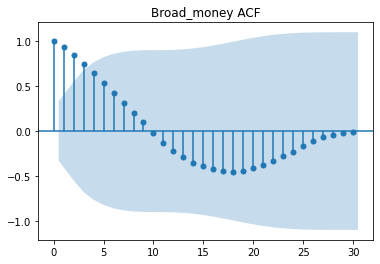

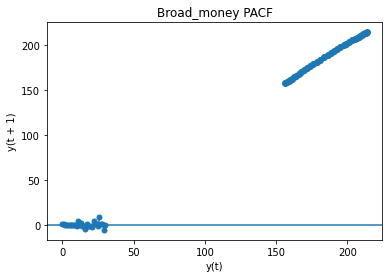

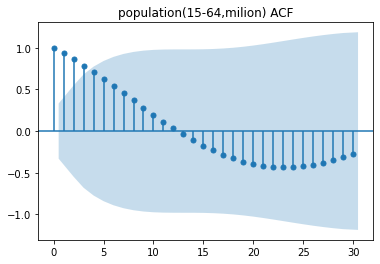

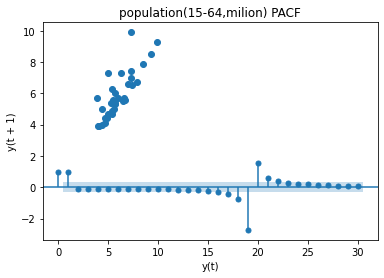

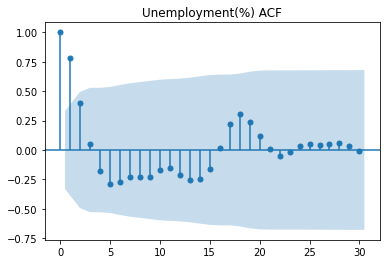

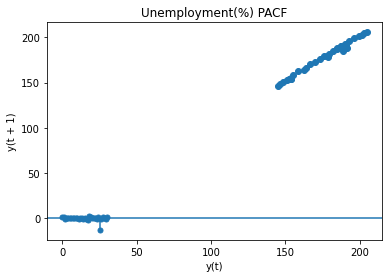

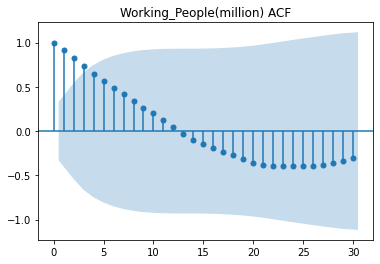

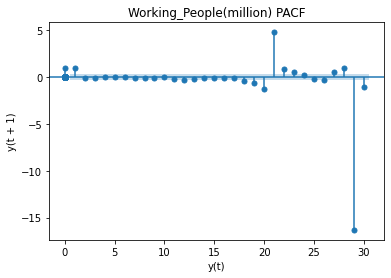

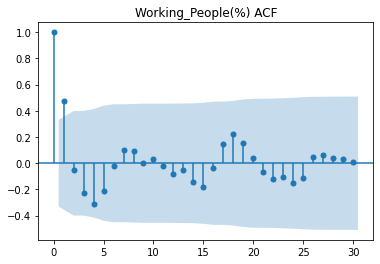

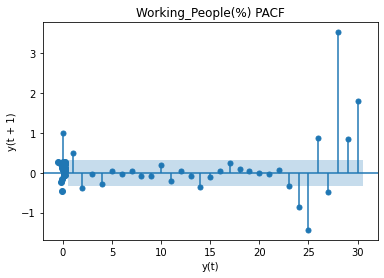

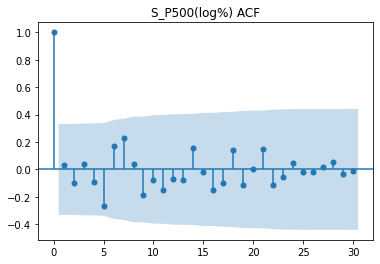

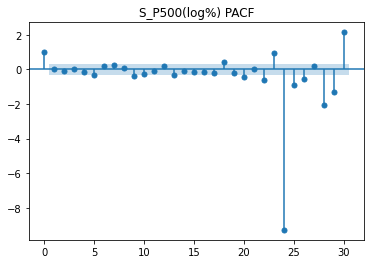

In [15]:
all_plot(USA.dropna(),acf= True)

In [9]:
#一定の期間の予測を行う関数を作成する
# FvsA_plot(USA.drop("GCE",axis = 1).drop("TRADE",axis = 1).drop("Turnover_Ratio",axis = 1).dropna())
# forecast_data(USA.drop("GCE",axis = 1).drop("TRADE",axis = 1).drop("Turnover_Ratio",axis = 1).dropna())

Augumented Dickey-Fuller Test:
ADS test statistic       1.413368
p-value                  0.997174
# lags used              9.000000
# observations          39.000000
Critical Value (1%)     -3.610400
Critical Value (5%)     -2.939109
Critical Value (10%)    -2.608063
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -1.822961
p-value                  0.369123
# lags used              8.000000
# observations          39.000000
Critical Value (1%)     -3.610400
Critical Value (5%)     -2.939109
Critical Value (10%)    -2.608063
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -1.426921
p-value                  0.569304
# lags used             10.000000
# observations          36.000000
Critical Value (1%)     -3.626652
Critical Value (5%)  

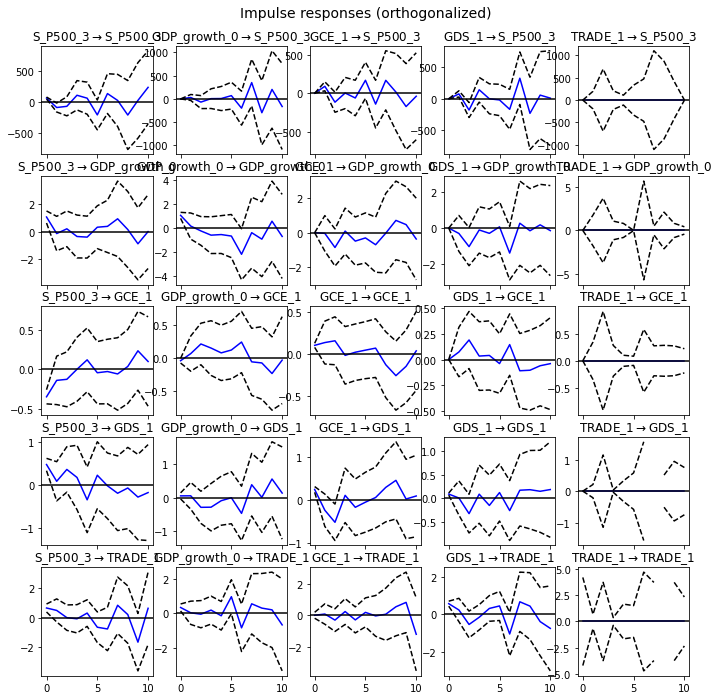

The function plots the Forecast Error Variance Decomposition
FEVD for S_P500_3
     S_P500_3  GDP_growth_0     GCE_1     GDS_1   TRADE_1
0    1.000000      0.000000  0.000000  0.000000  0.000000
1    0.443378      0.035971  0.298579  0.222071  0.000000
2    0.199330      0.069126  0.265038  0.466505  0.000000
3    0.255279      0.049201  0.187523  0.507997  0.000000
4    0.274439      0.046441  0.205550  0.473571  0.000000

FEVD for GDP_growth_0
     S_P500_3  GDP_growth_0     GCE_1     GDS_1   TRADE_1
0    0.487085      0.512915  0.000000  0.000000  0.000000
1    0.466530      0.495959  0.000529  0.036982  0.000000
2    0.270365      0.289401  0.172630  0.267604  0.000000
3    0.269337      0.330361  0.157229  0.243073  0.000000
4    0.260918      0.335315  0.178773  0.224994  0.000000

FEVD for GCE_1
     S_P500_3  GDP_growth_0     GCE_1     GDS_1   TRADE_1
0    0.908023      0.012196  0.079780  0.000000  0.000000
1    0.774845      0.034680  0.160270  0.030205  0.000000
2    0.51330

{'S_P500_3': 6, 'GDP_growth_0': 2, 'GCE_1': 4, 'GDS_1': 6, 'TRADE_1': 2}

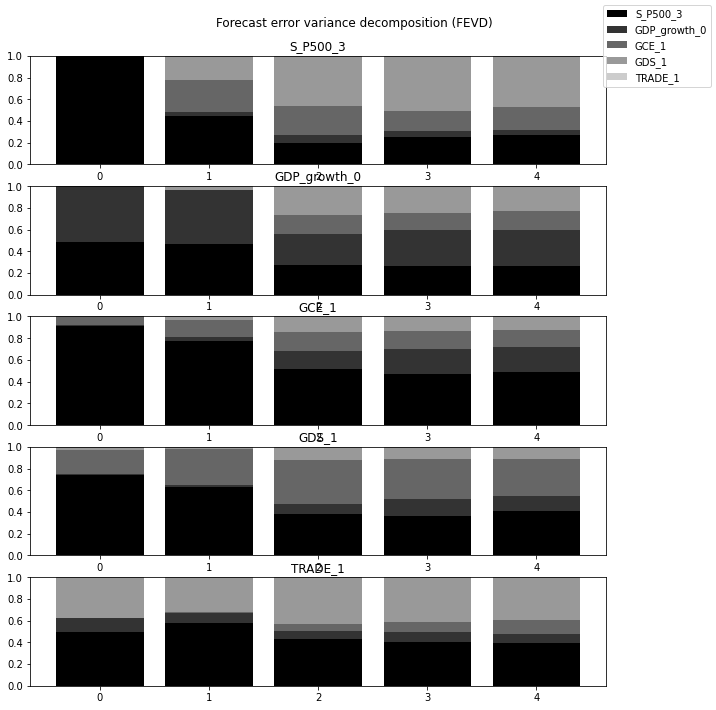

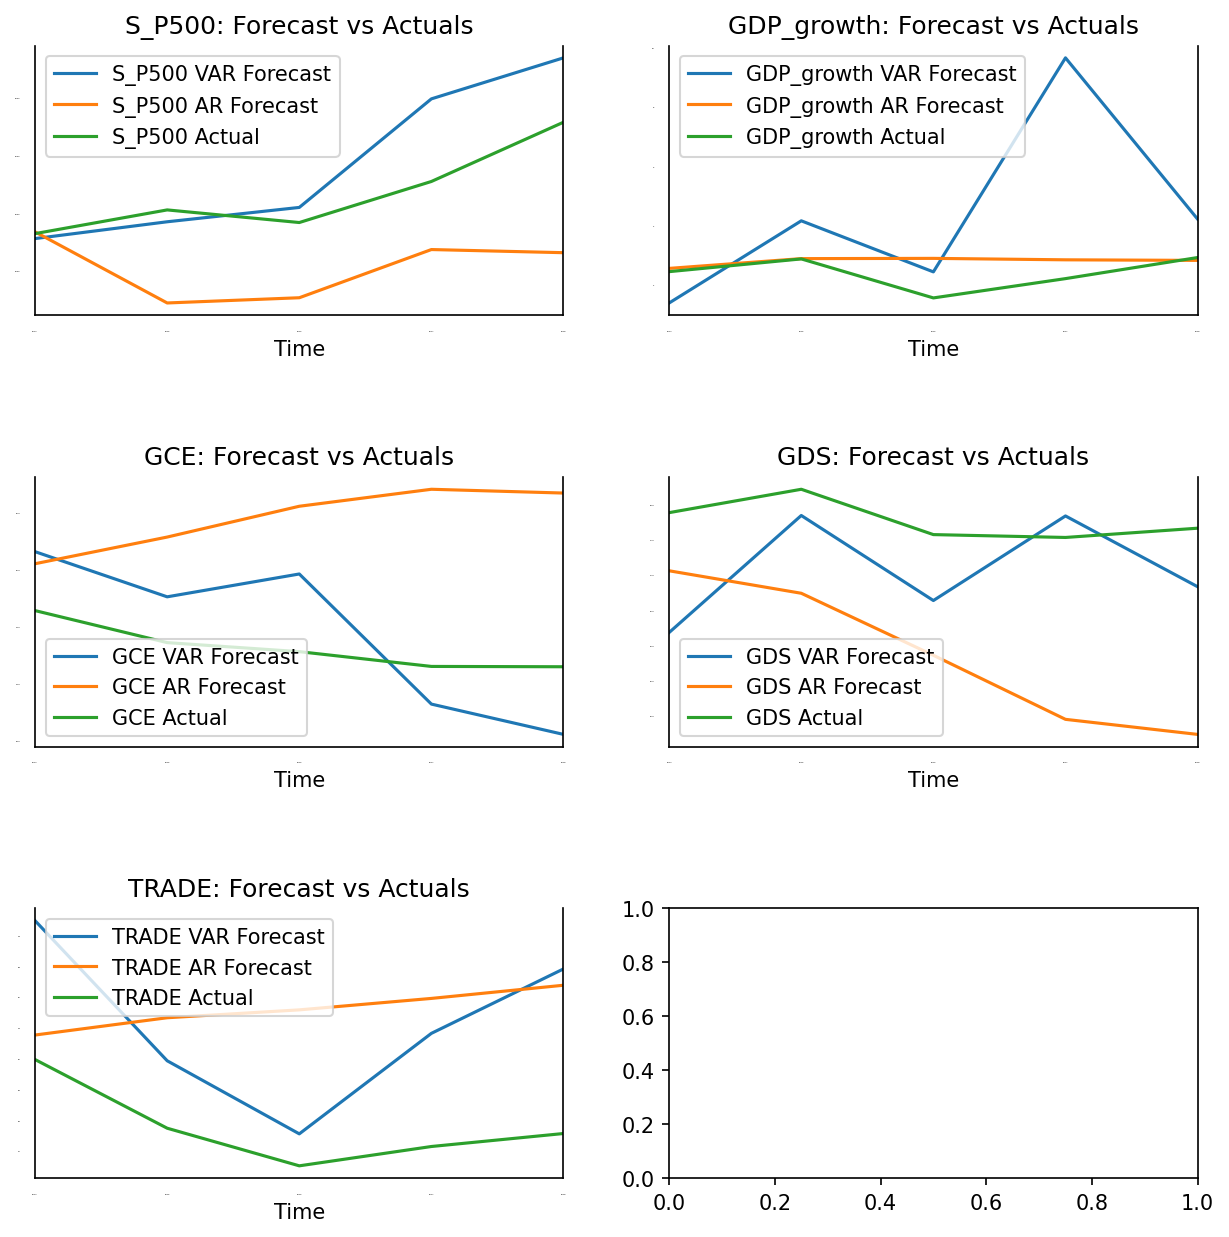

In [19]:
#ここから下で変数を定常にしてVARモデルで予測する．
VAR_AR_plot_evaluation(USA[["S_P500","GDP_growth","GCE","GDS","TRADE"]].dropna())
#GDPP is not better to be included
#RIR, BCP, Turnover_Ratio, Broad_money returns
# GDPPとTradeは同時に入れるとnot positive definite になる

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GDS    ::  66.02     > 46.5716   =>   True
GDP_growth ::  26.89     > 29.5147   =>   False
Working_People(million) ::  8.65      > 16.364    =>   False
S_P500 ::  0.03      > 6.9406    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic      -0.838089
p-value                  0.807677
# lags used              4.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -5.170263
p-value                  0.000010
# lags used              3.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Strong evidence against the null hypothesis
Reject the nu

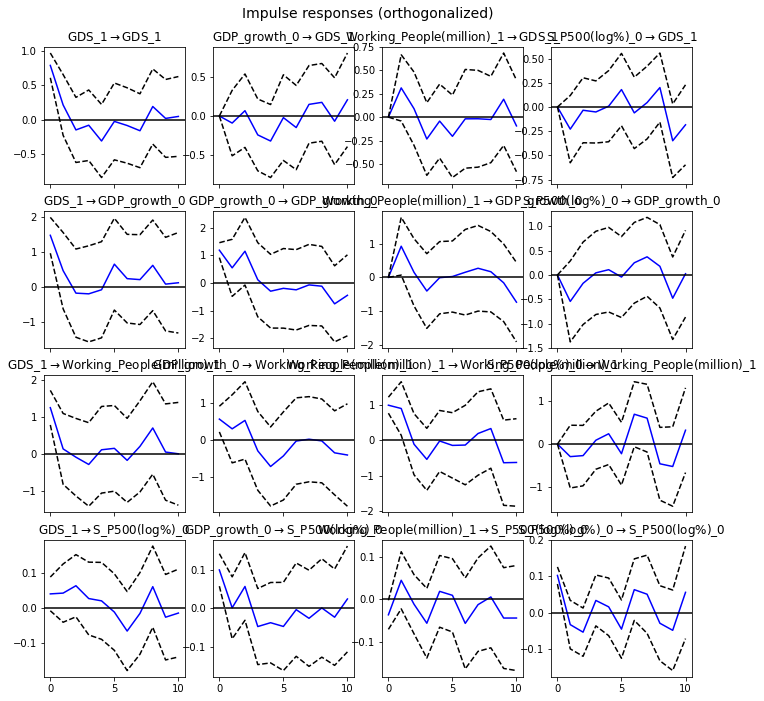

The function plots the Forecast Error Variance Decomposition
FEVD for GDS_1
        GDS_1  GDP_growth_0  Working_People(million)_1  S_P500(log%)_0
0    1.000000      0.000000                   0.000000        0.000000
1    0.810110      0.009978                   0.117281        0.062631
2    0.801828      0.014972                   0.121841        0.061358
3    0.708371      0.073287                   0.161969        0.056373
4    0.668455      0.148507                   0.136127        0.046911

FEVD for GDP_growth_0
        GDS_1  GDP_growth_0  Working_People(million)_1  S_P500(log%)_0
0    0.607817      0.392183                   0.000000        0.000000
1    0.457049      0.324389                   0.162662        0.055899
2    0.365239      0.454295                   0.131894        0.048572
3    0.358873      0.442091                   0.151706        0.047331
4    0.354132      0.448157                   0.149423        0.048288

FEVD for Working_People(million)_1
        GDS_1

{'GDS_1': 4,
 'GDP_growth_0': 6,
 'Working_People(million)_1': 2,
 'S_P500(log%)_0': 1}

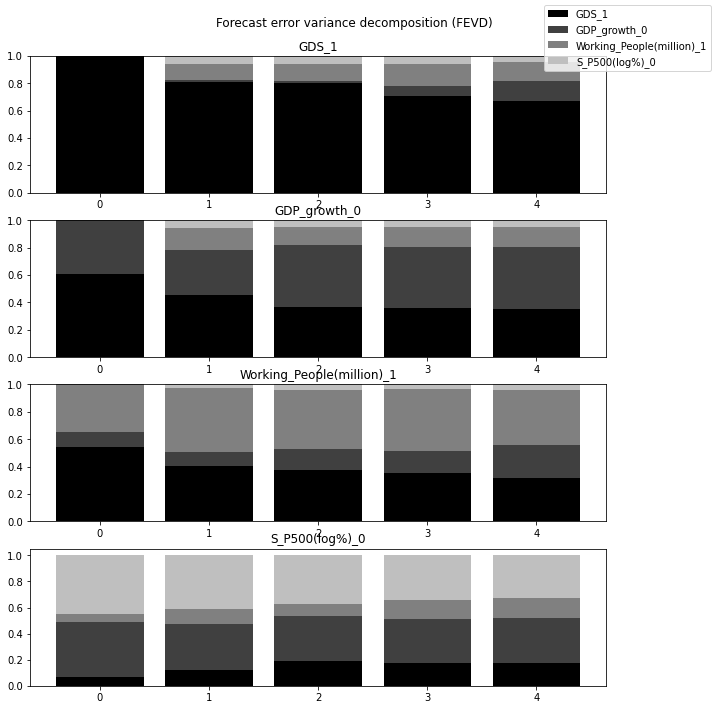

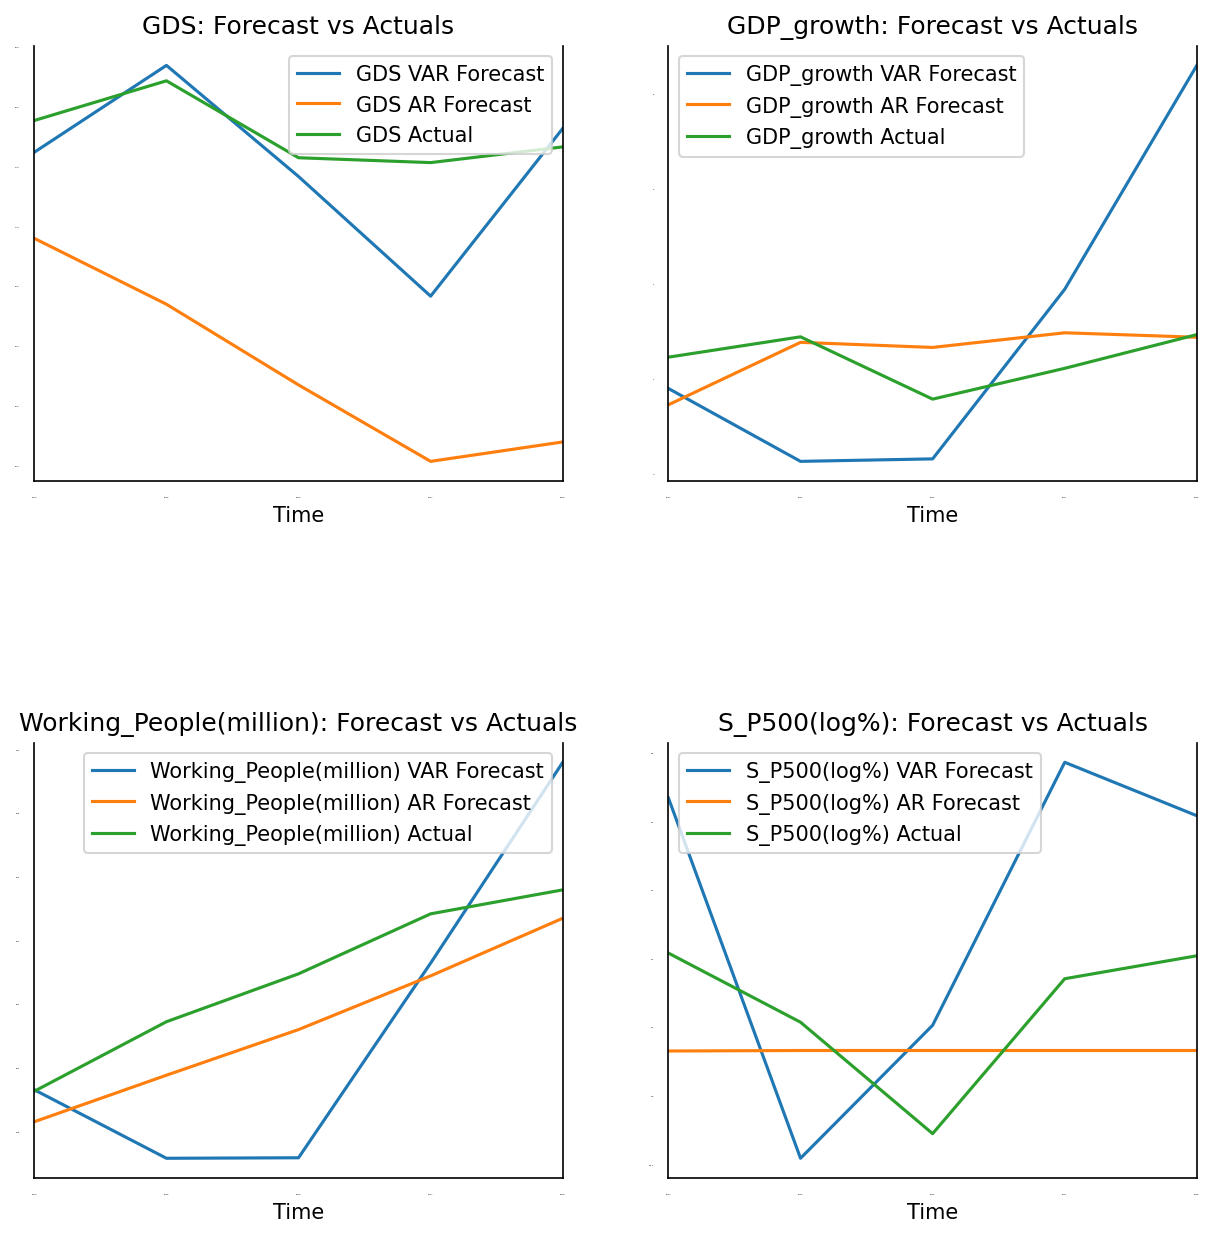

In [28]:
cointegration_test(USA[["GDS","GDP_growth","Working_People(million)","S_P500"]].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation(USA[["GDS","GDP_growth","Working_People(million)","S_P500(log%)"]].dropna())
#VAR_AR_plot_evaluation_nodiff(USA[["S_P500","GDP_growth","GCE","GDS"]].dropna())

Augumented Dickey-Fuller Test:
ADS test statistic      -0.838089
p-value                  0.807677
# lags used              4.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -5.170263
p-value                  0.000010
# lags used              3.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
GDS needs 1 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -5.271776
p-value                  0.000006
# lags used              0.000000
# observations 

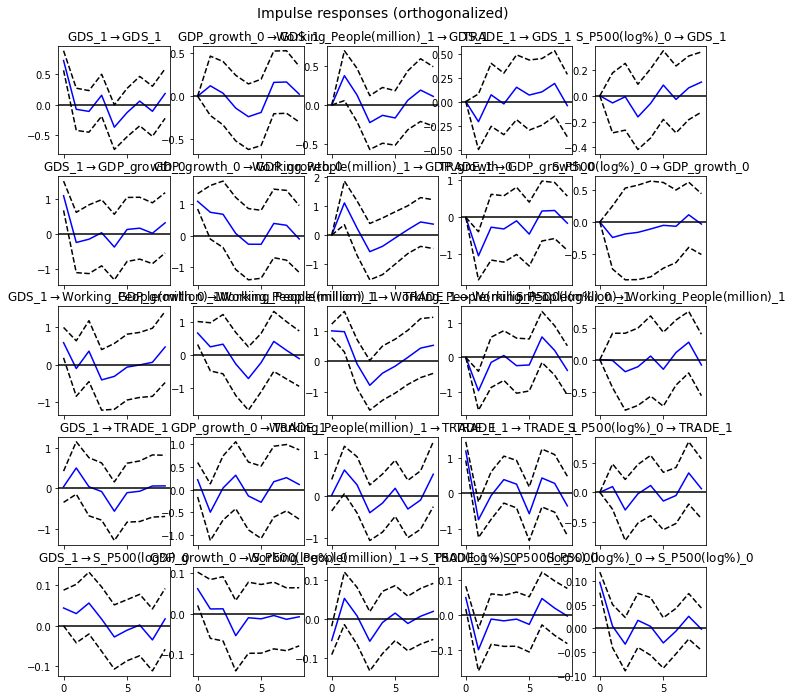

The function plots the Forecast Error Variance Decomposition
FEVD for GDS_1
        GDS_1  GDP_growth_0  Working_People(million)_1   TRADE_1  S_P500(log%)_0
0    1.000000      0.000000                   0.000000  0.000000        0.000000
1    0.728182      0.019866                   0.188464  0.059333        0.004154
2    0.711502      0.020548                   0.200723  0.063174        0.004053
3    0.642863      0.039619                   0.228898  0.055279        0.033341
4    0.628916      0.082446                   0.195848  0.063379        0.029410

FEVD for GDP_growth_0
        GDS_1  GDP_growth_0  Working_People(million)_1   TRADE_1  S_P500(log%)_0
0    0.497933      0.502067                   0.000000  0.000000        0.000000
1    0.231779      0.325678                   0.230463  0.201220        0.010860
2    0.210657      0.367722                   0.214901  0.191257        0.015463
3    0.195817      0.342520                   0.250279  0.192978        0.018406
4    0.205

{'GDS_1': 4,
 'GDP_growth_0': 1,
 'Working_People(million)_1': 2,
 'TRADE_1': 4,
 'S_P500(log%)_0': 1}

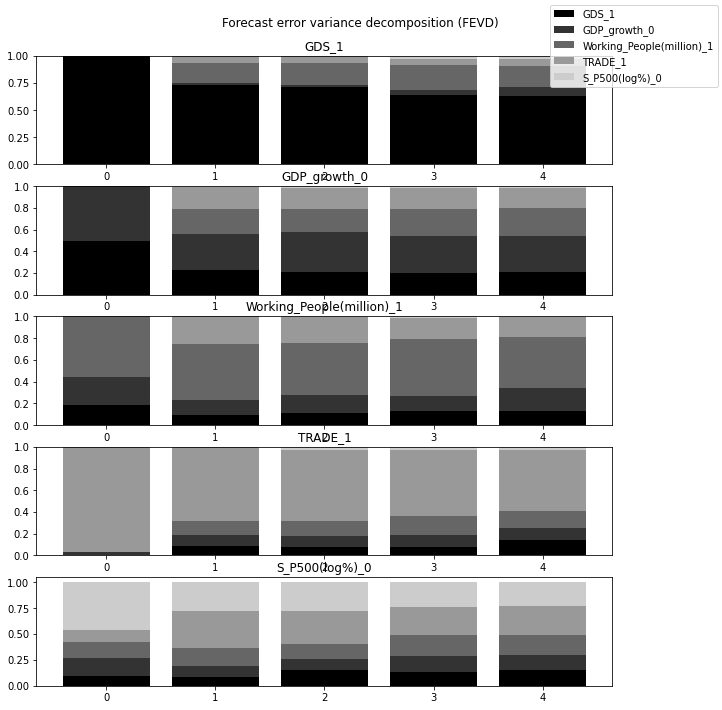

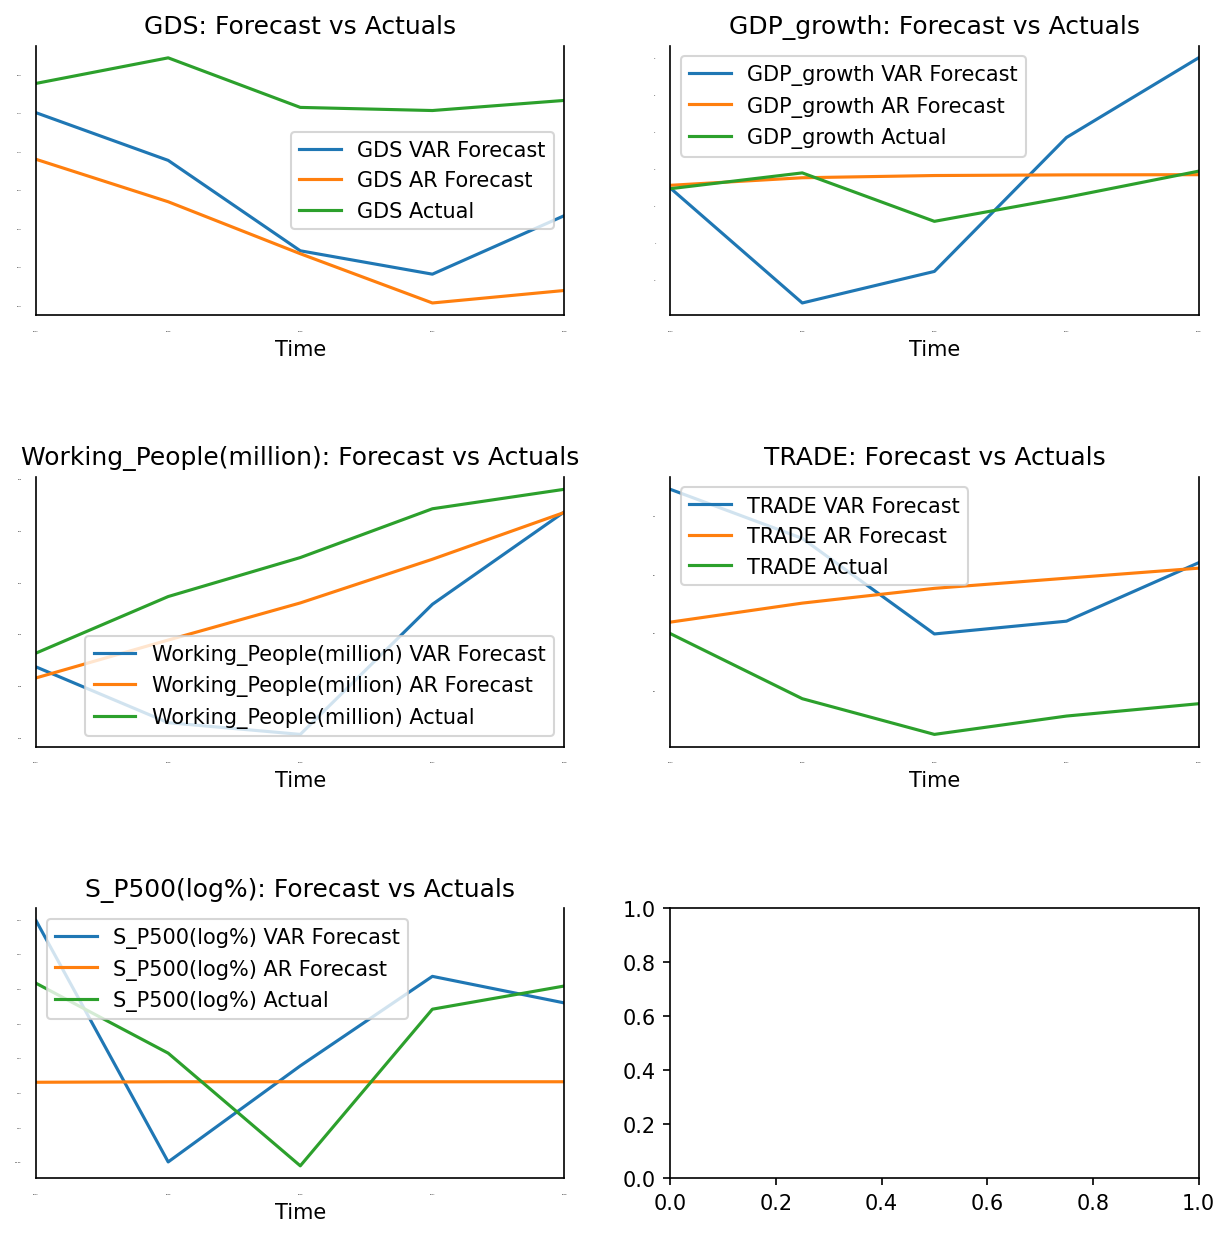

In [29]:
VAR_AR_plot_evaluation(USA[["GDS","GDP_growth","Working_People(million)","TRADE","S_P500(log%)"]].dropna(),order=5)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GDS    ::  66.02     > 40.1749   =>   True
GDP_growth ::  26.89     > 24.2761   =>   True
Working_People(million) ::  8.65      > 12.3212   =>   False
S_P500 ::  0.03      > 4.1296    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic      -0.838089
p-value                  0.807677
# lags used              4.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -5.170263
p-value                  0.000010
# lags used              3.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Strong evidence against the null hypothesis
Reject the nul

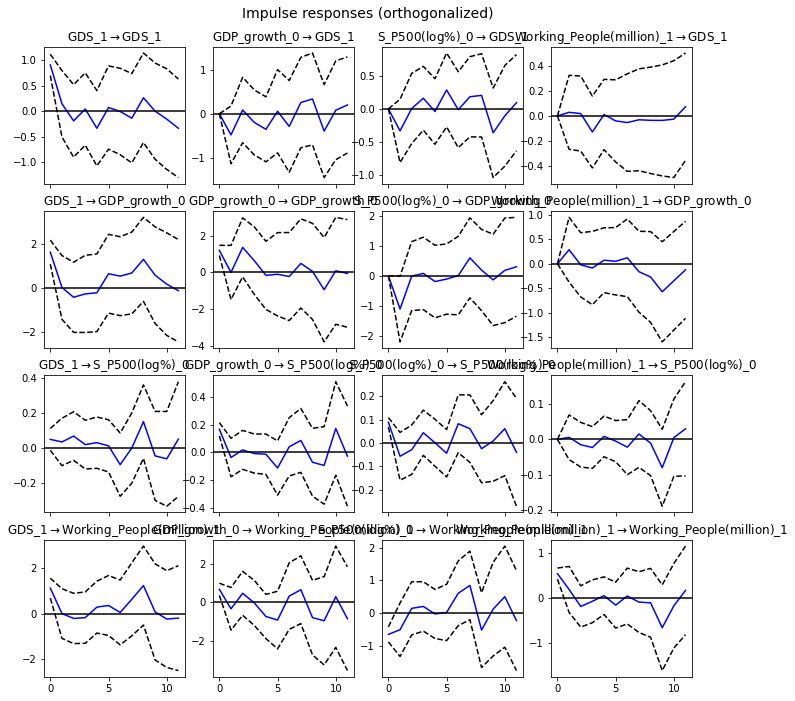

The function plots the Forecast Error Variance Decomposition
FEVD for GDS_1
        GDS_1  GDP_growth_0  S_P500(log%)_0  Working_People(million)_1
0    1.000000      0.000000        0.000000                   0.000000
1    0.711901      0.194106        0.093310                   0.000684
2    0.715903      0.193180        0.089971                   0.000946
3    0.672016      0.210498        0.104089                   0.013397
4    0.641146      0.258414        0.089028                   0.011411

FEVD for GDP_growth_0
        GDS_1  GDP_growth_0  S_P500(log%)_0  Working_People(million)_1
0    0.651470      0.348530        0.000000                   0.000000
1    0.495798      0.265078        0.223851                   0.015273
2    0.382805      0.442956        0.163057                   0.011182
3    0.367191      0.467467        0.153904                   0.011438
4    0.367273      0.464482        0.156286                   0.011959

FEVD for S_P500(log%)_0
        GDS_1  GDP_growt

{'GDS_1': 4,
 'GDP_growth_0': 6,
 'S_P500(log%)_0': 1,
 'Working_People(million)_1': 2}

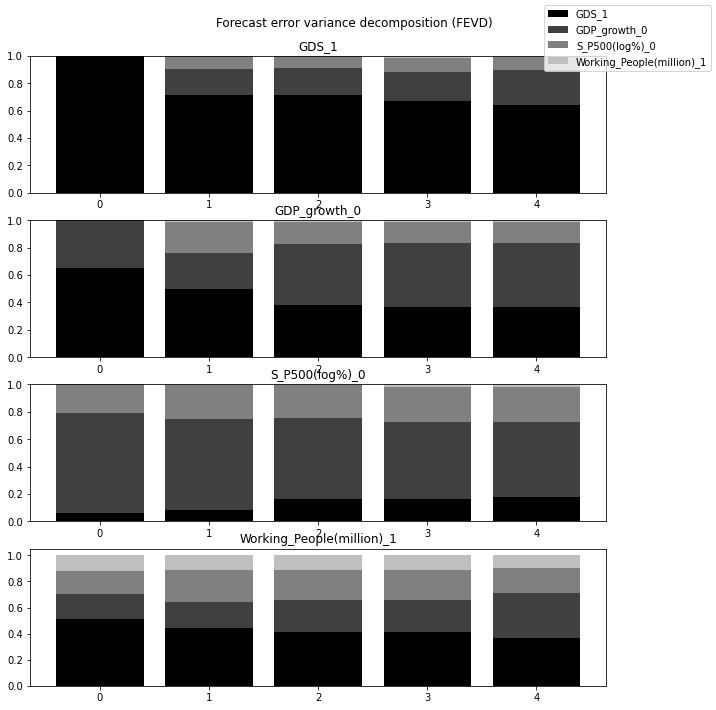

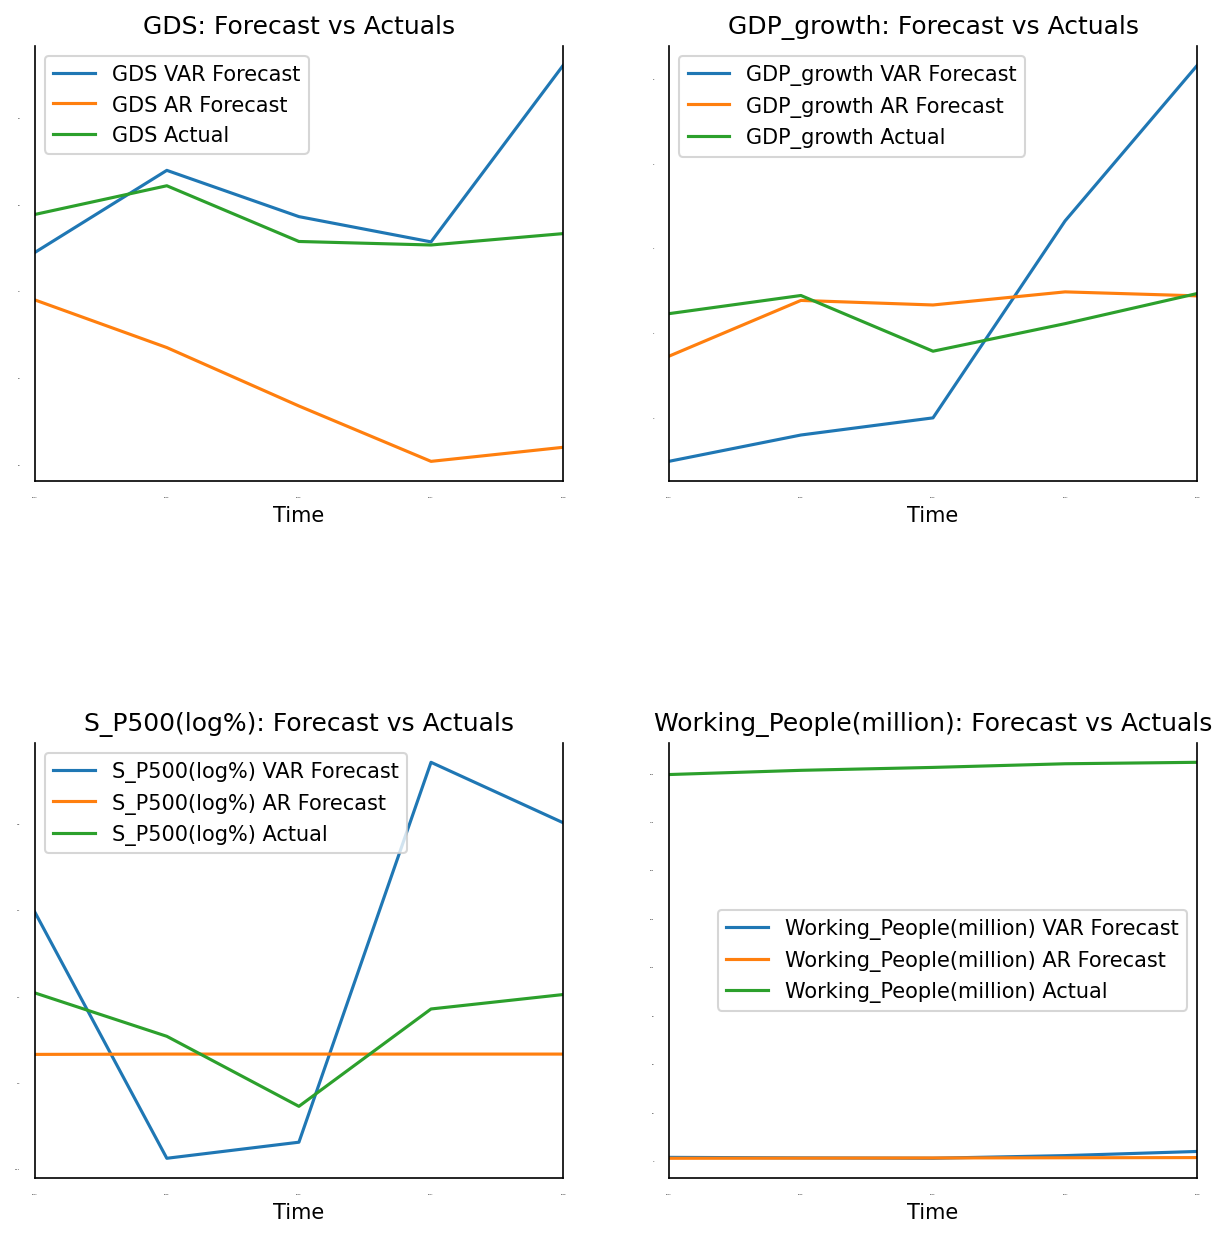

In [30]:
cointegration_test(USA[["GDS","GDP_growth","Working_People(million)","S_P500"]].dropna())
VAR_AR_plot_evaluation(USA[["GDS","GDP_growth","S_P500(log%)","Working_People(million)"]].dropna(),order=8)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GDS    ::  76.28     > 40.1749   =>   True
GDP_growth ::  29.85     > 24.2761   =>   True
Working_People(%) ::  11.54     > 12.3212   =>   False
S_P500 ::  0.97      > 4.1296    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic     -7.692329e+00
p-value                 1.408486e-11
# lags used             0.000000e+00
# observations          5.800000e+01
Critical Value (1%)    -3.548494e+00
Critical Value (5%)    -2.912837e+00
Critical Value (10%)   -2.594129e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
S_P500(log%) needs 0 times difference to obtain stationary
--------------------------------
Augumented Dickey-Fuller Test:
ADS test statistic      -5.334016
p-value                  0.000005
# lags used              0.000000
# observations          58.000000
Critical Value (1%)     -3.548494
Critical Value (5%)     -2.9

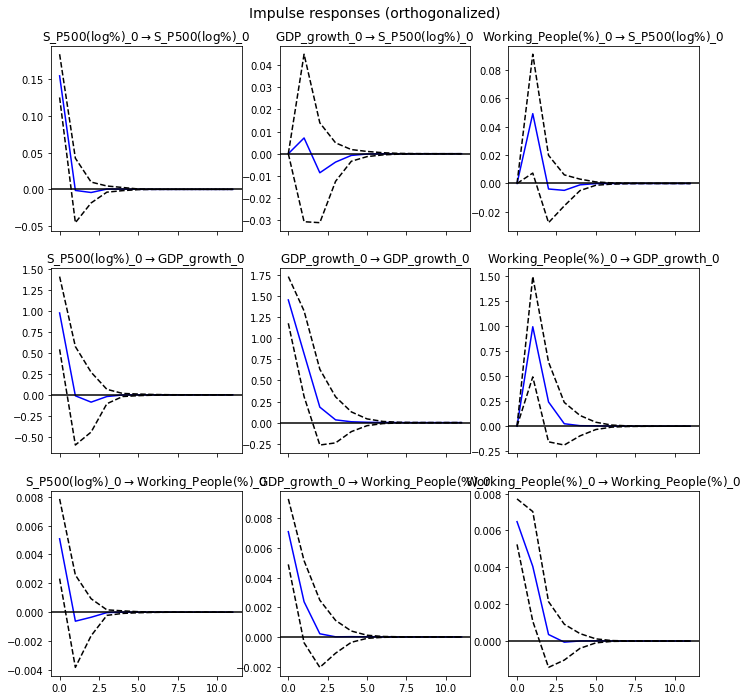

The function plots the Forecast Error Variance Decomposition
FEVD for S_P500(log%)_0
     S_P500(log%)_0  GDP_growth_0  Working_People(%)_0
0          1.000000      0.000000             0.000000
1          0.906141      0.001932             0.091927
2          0.903129      0.004743             0.092128
3          0.901832      0.005281             0.092887
4          0.901779      0.005303             0.092918

FEVD for GDP_growth_0
     S_P500(log%)_0  GDP_growth_0  Working_People(%)_0
0          0.309958      0.690042             0.000000
1          0.201551      0.590010             0.208439
2          0.198954      0.584782             0.216264
3          0.198954      0.584748             0.216298
4          0.198949      0.584753             0.216298

FEVD for Working_People(%)_0
     S_P500(log%)_0  GDP_growth_0  Working_People(%)_0
0          0.219146      0.425822             0.355032
1          0.186967      0.397960             0.415074
2          0.187445      0.397454    

{'S_P500(log%)_0': 1, 'GDP_growth_0': 2, 'Working_People(%)_0': 2}

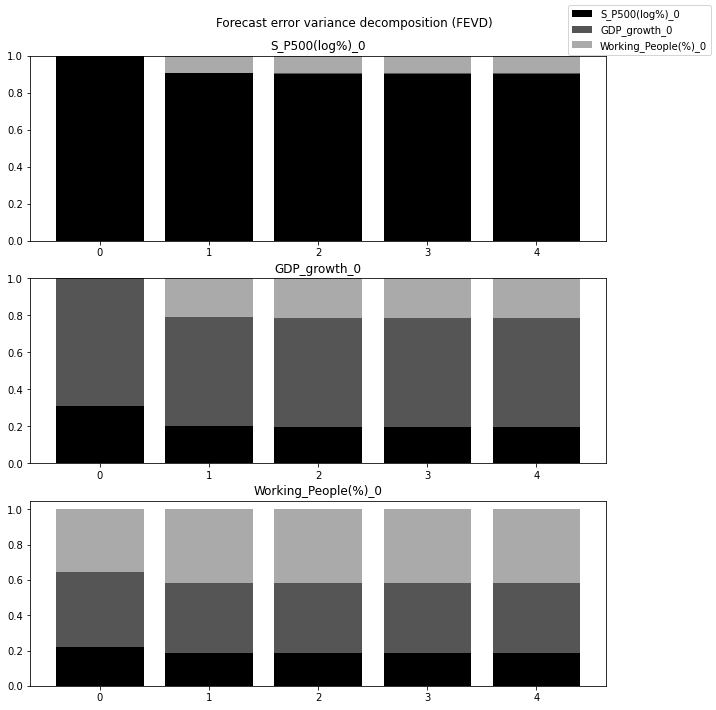

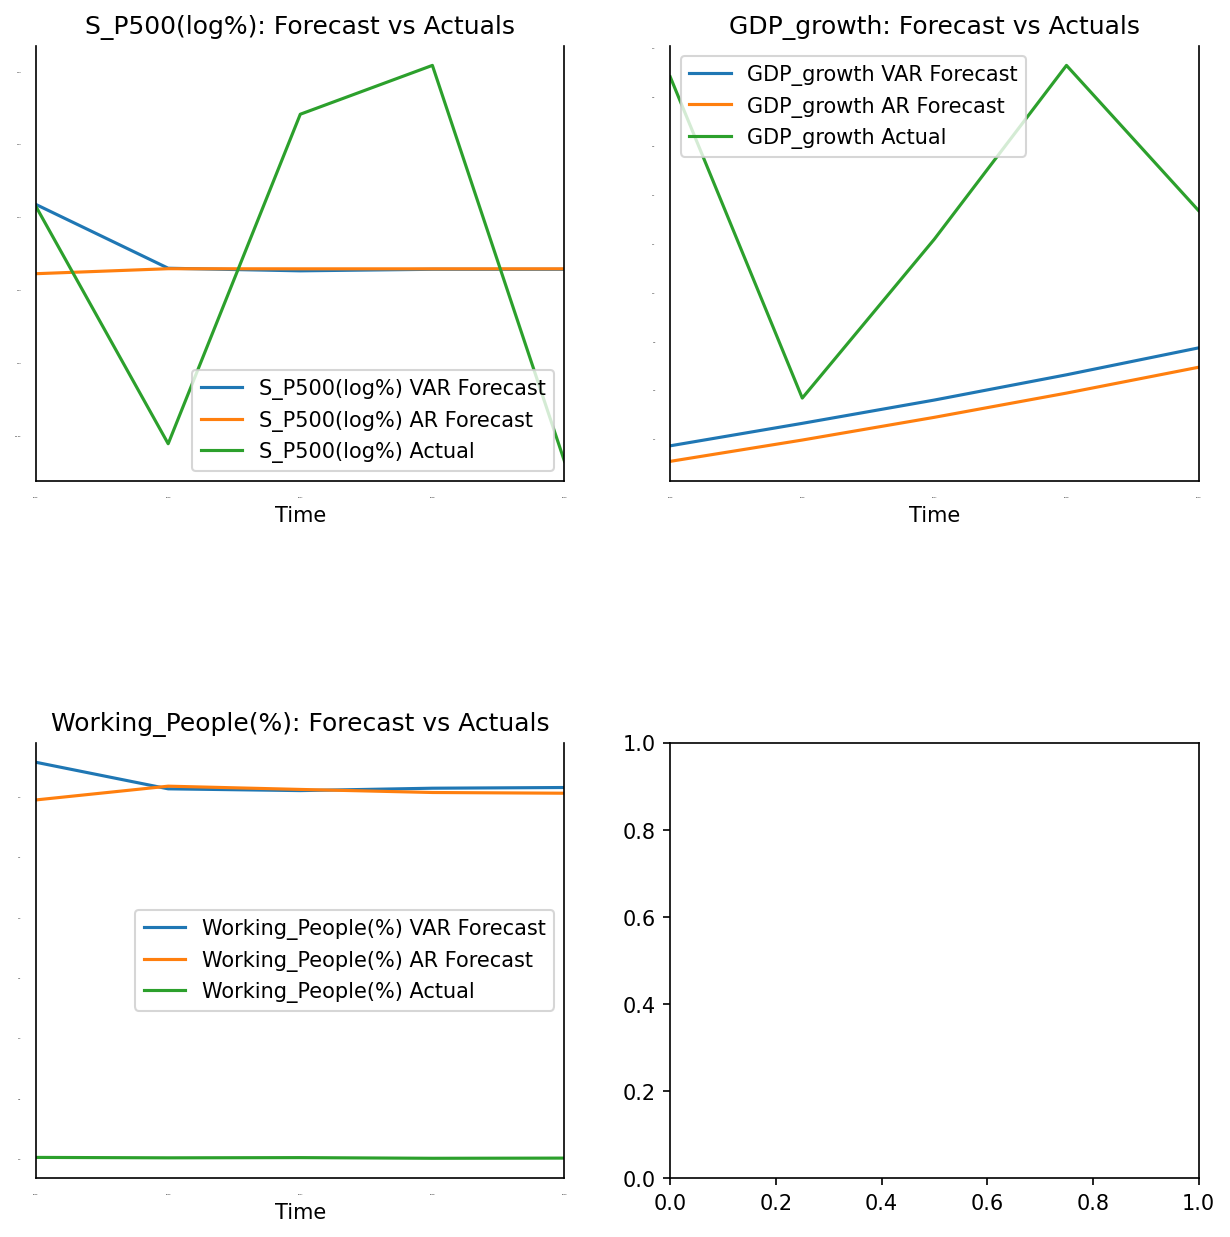

In [31]:
cointegration_test(USA[["GDS","GDP_growth","Working_People(%)","S_P500"]].dropna())
VAR_AR_plot_evaluation(USA[["S_P500(log%)","GDP_growth","Working_People(%)"]].dropna(),order=8)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GDS    ::  76.28     > 40.1749   =>   True
GDP_growth ::  29.85     > 24.2761   =>   True
Working_People(%) ::  11.54     > 12.3212   =>   False
S_P500 ::  0.97      > 4.1296    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic      -0.838089
p-value                  0.807677
# lags used              4.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -5.170263
p-value                  0.000010
# lags used              3.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Strong evidence against the null hypothesis
Reject the null hypo

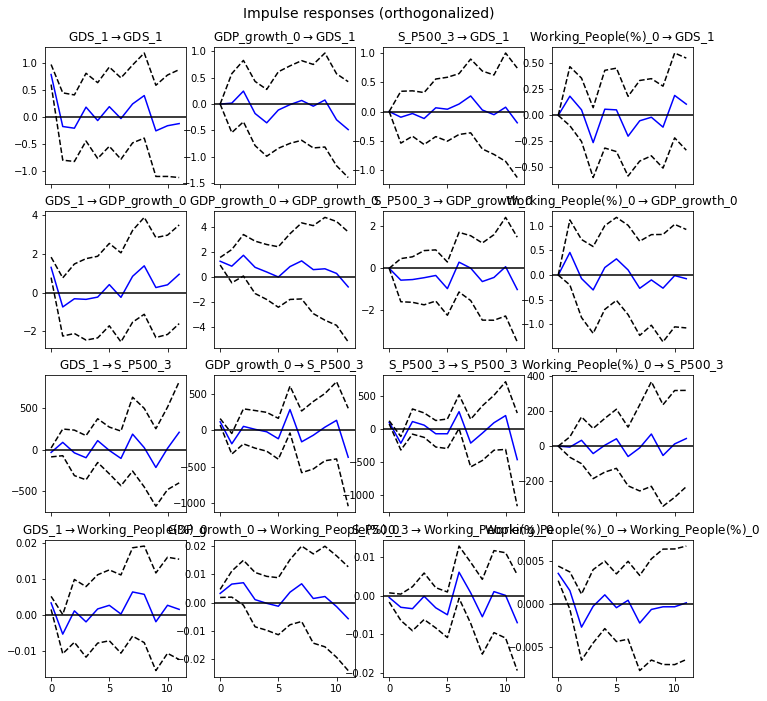

The function plots the Forecast Error Variance Decomposition
FEVD for GDS_1
        GDS_1  GDP_growth_0  S_P500_3  Working_People(%)_0
0    1.000000      0.000000  0.000000             0.000000
1    0.936508      0.000476  0.013494             0.049523
2    0.864352      0.076307  0.013059             0.046282
3    0.763959      0.098390  0.025983             0.111668
4    0.670576      0.202486  0.026348             0.100590

FEVD for GDP_growth_0
        GDS_1  GDP_growth_0  S_P500_3  Working_People(%)_0
0    0.509594      0.490406  0.000000             0.000000
1    0.433133      0.463472  0.062267             0.041128
2    0.271218      0.632671  0.070918             0.025194
3    0.254864      0.628921  0.084257             0.031959
4    0.251023      0.622951  0.092860             0.033166

FEVD for S_P500_3
        GDS_1  GDP_growth_0  S_P500_3  Working_People(%)_0
0    0.047950      0.544167  0.407883             0.000000
1    0.075639      0.423256  0.500876             0.0002

{'GDS_1': 6, 'GDP_growth_0': 2, 'S_P500_3': 7, 'Working_People(%)_0': 2}

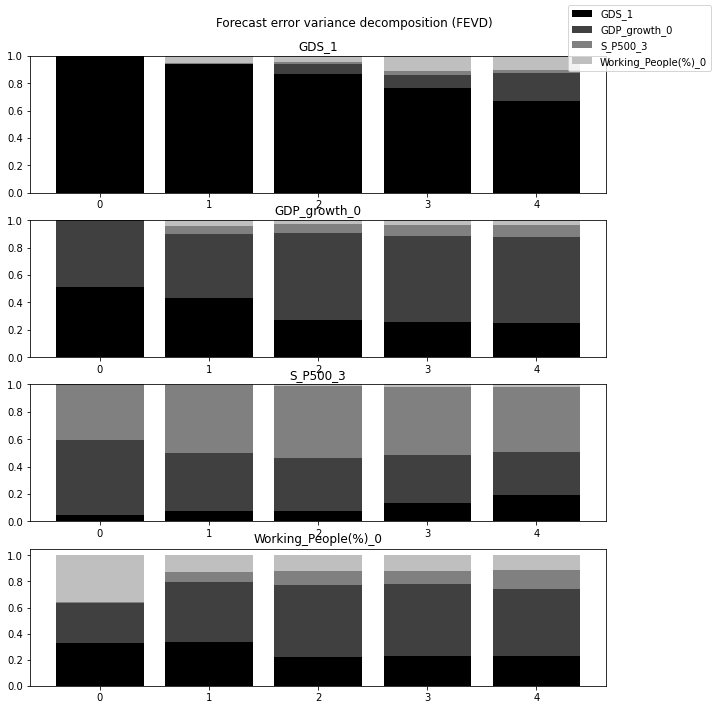

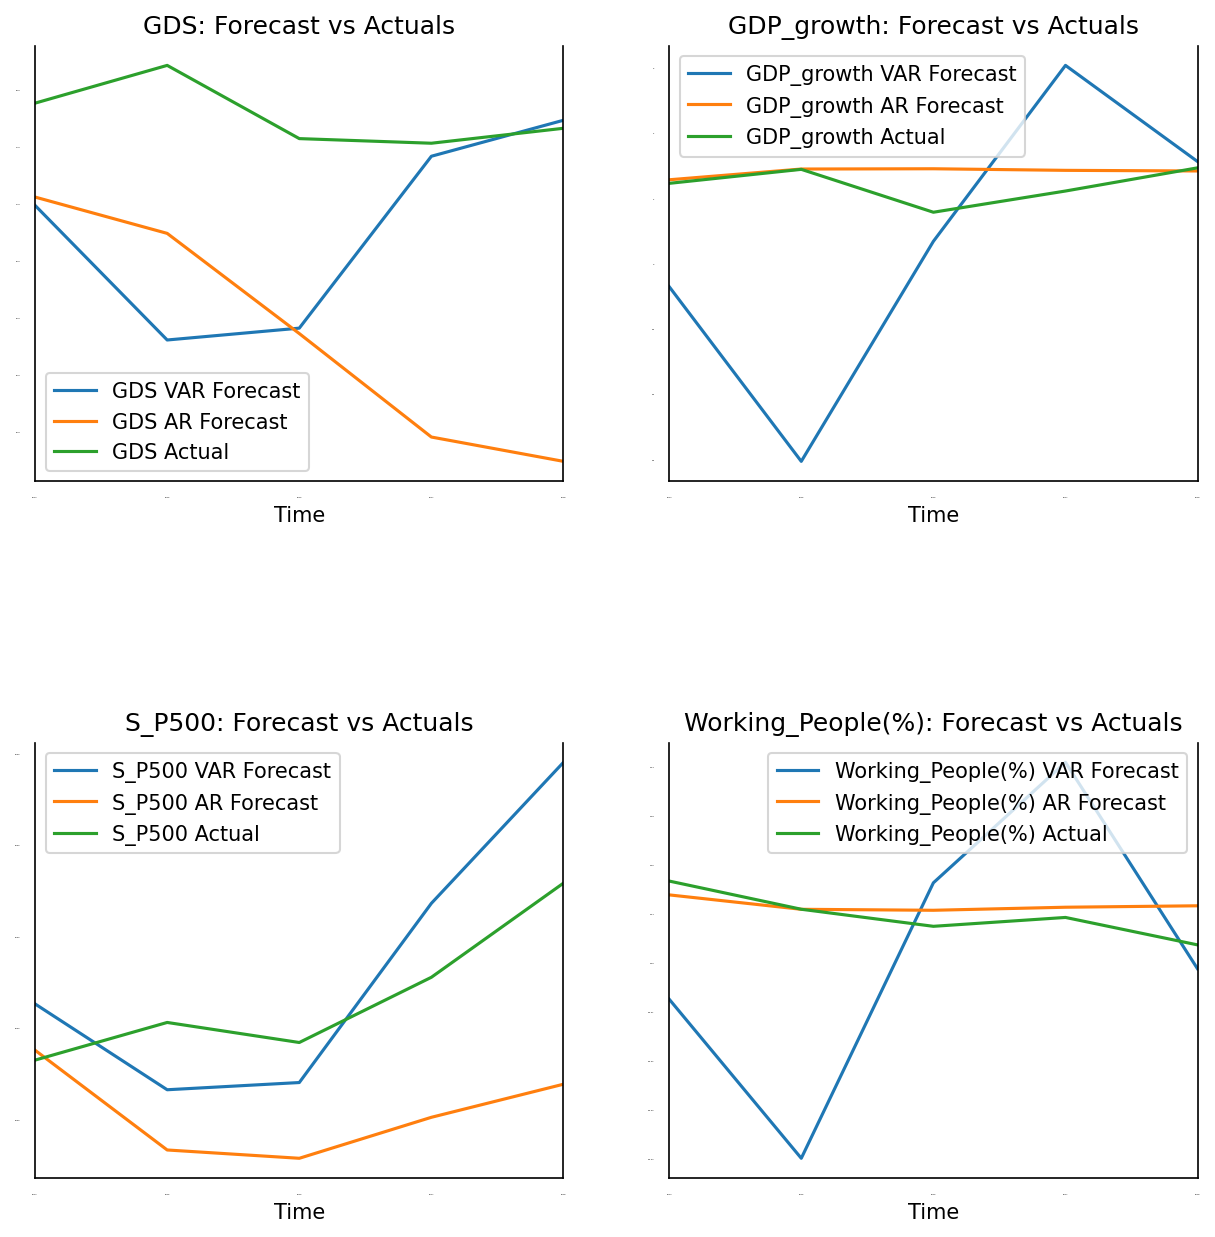

In [32]:
cointegration_test(USA[["GDS","GDP_growth","Working_People(%)","S_P500"]].dropna())
VAR_AR_plot_evaluation(USA[["GDS","GDP_growth","S_P500","Working_People(%)"]].dropna(),order=8)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GDS    ::  30.63     > 24.2761   =>   True
Working_People(million) ::  11.57     > 12.3212   =>   False
S_P500 ::  1.08      > 4.1296    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic      -0.838089
p-value                  0.807677
# lags used              4.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -5.170263
p-value                  0.000010
# lags used              3.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stati

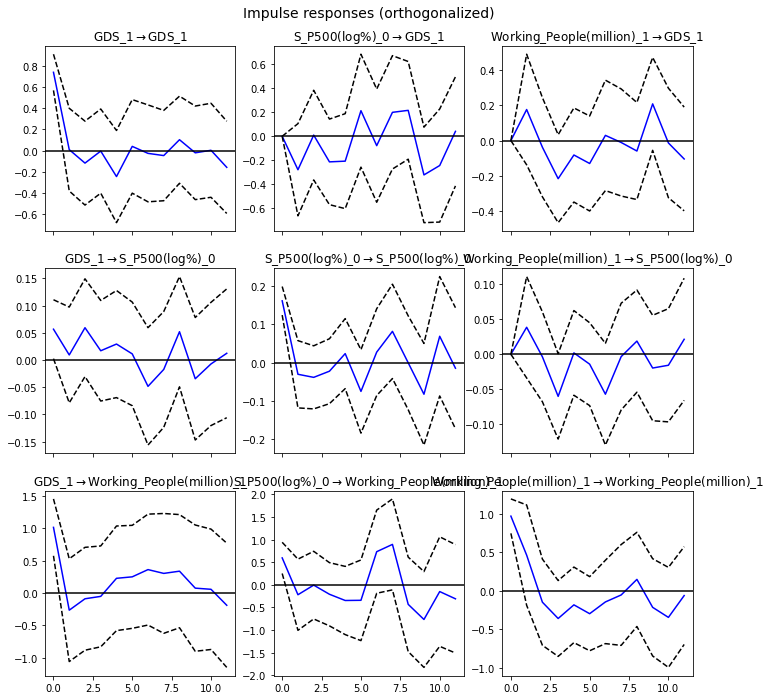

The function plots the Forecast Error Variance Decomposition
FEVD for GDS_1
        GDS_1  S_P500(log%)_0  Working_People(million)_1
0    1.000000        0.000000                   0.000000
1    0.833640        0.118556                   0.047804
2    0.835211        0.115970                   0.048819
3    0.733997        0.161461                   0.104542
4    0.710550        0.190362                   0.099088

FEVD for S_P500(log%)_0
        GDS_1  S_P500(log%)_0  Working_People(million)_1
0    0.110639        0.889361                   0.000000
1    0.104636        0.847904                   0.047460
2    0.186832        0.771861                   0.041307
3    0.173793        0.700808                   0.125399
4    0.188367        0.690324                   0.121309

FEVD for Working_People(million)_1
        GDS_1  S_P500(log%)_0  Working_People(million)_1
0    0.443066        0.152188                   0.404746
1    0.413954        0.151493                   0.434553
2    0.4

{'GDS_1': 4, 'S_P500(log%)_0': 1, 'Working_People(million)_1': 2}

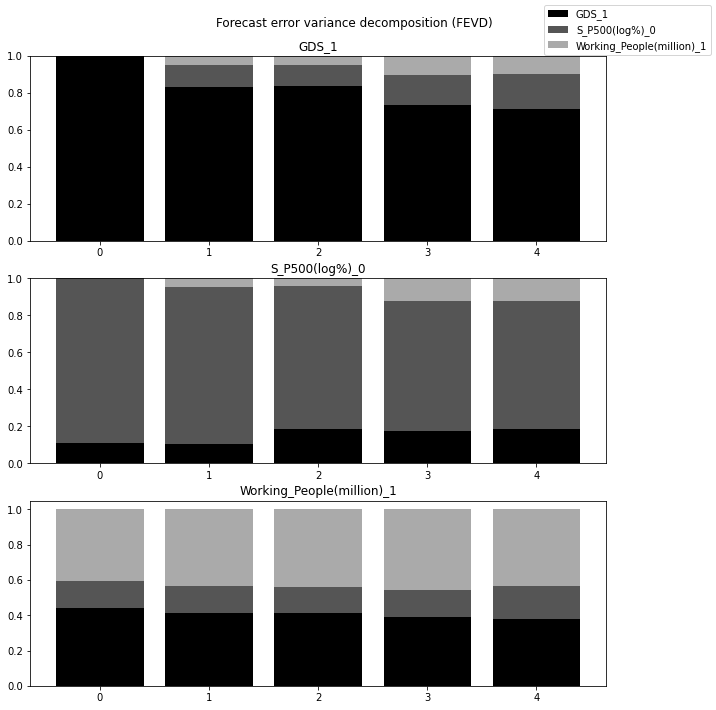

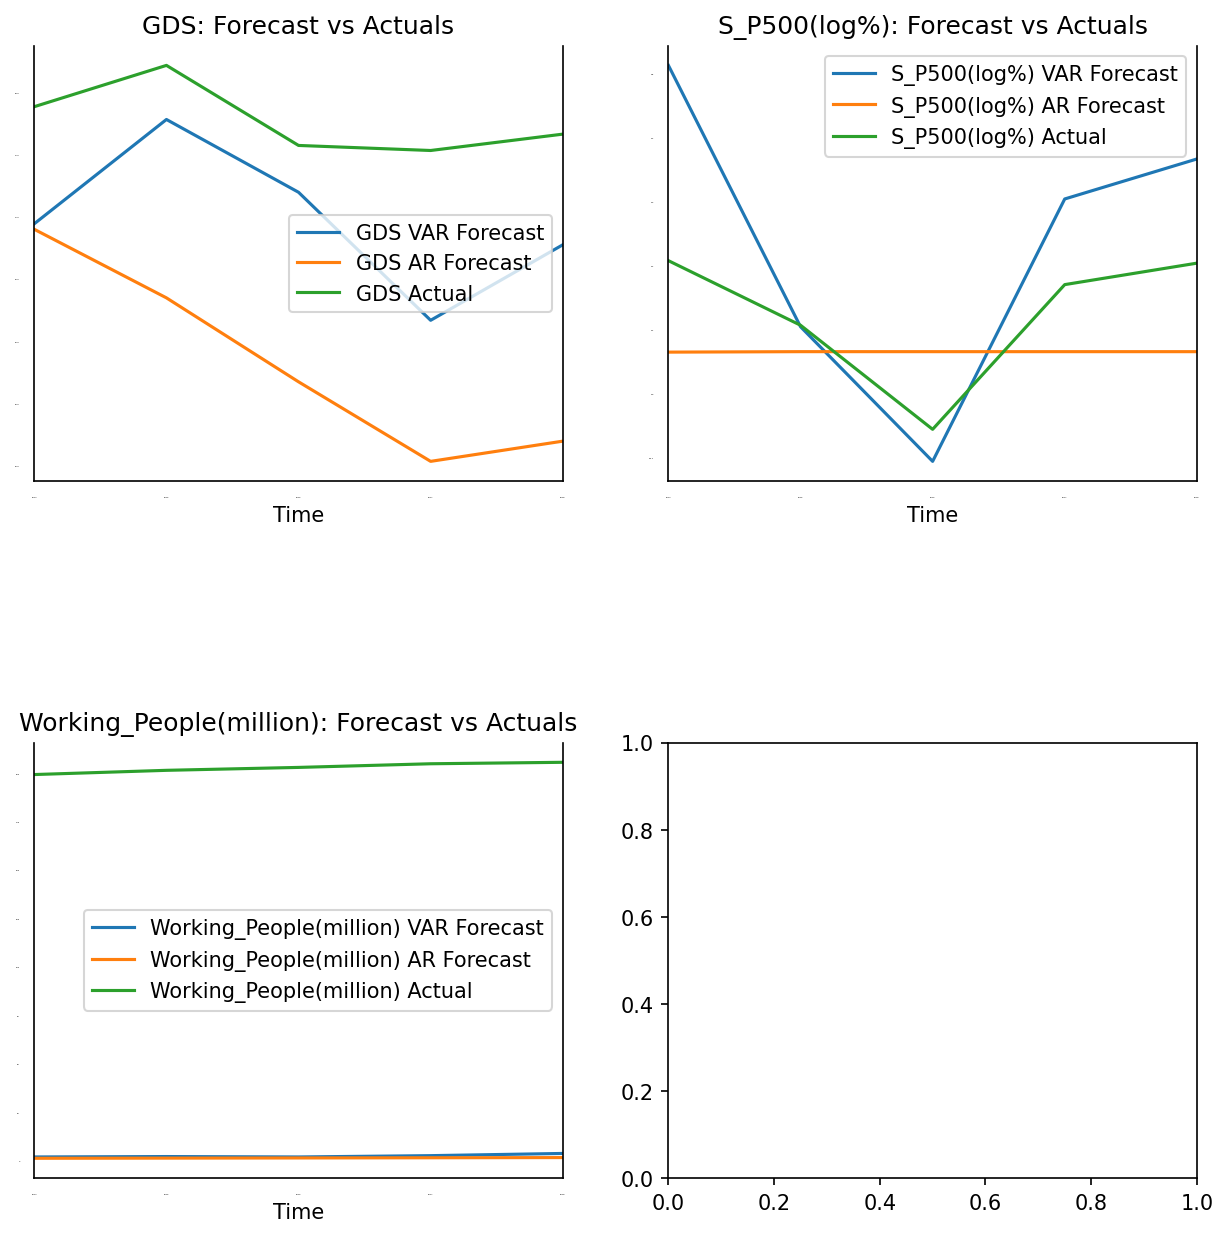

In [46]:
cointegration_test(USA[["GDS","Working_People(million)","S_P500"]].dropna())
VAR_AR_plot_evaluation(USA[["GDS","S_P500(log%)","Working_People(million)"]].dropna(),order=8)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GDS    ::  30.84     > 24.2761   =>   True
Working_People(%) ::  9.94      > 12.3212   =>   False
S_P500 ::  0.57      > 4.1296    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic      -0.838089
p-value                  0.807677
# lags used              4.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -5.170263
p-value                  0.000010
# lags used              3.000000
# observations          44.000000
Critical Value (1%)     -3.588573
Critical Value (5%)     -2.929886
Critical Value (10%)    -2.603185
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


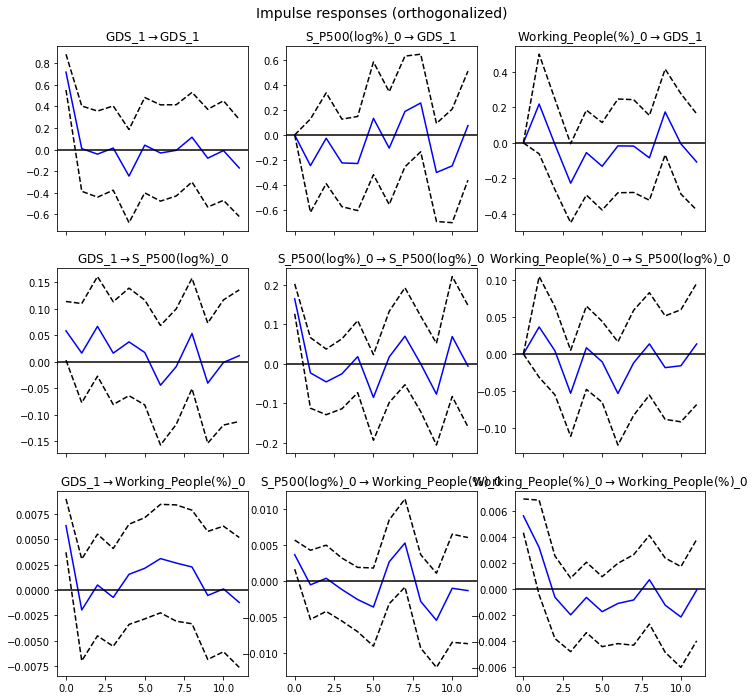

The function plots the Forecast Error Variance Decomposition
FEVD for GDS_1
        GDS_1  S_P500(log%)_0  Working_People(%)_0
0    1.000000        0.000000             0.000000
1    0.825145        0.097851             0.077004
2    0.824630        0.098571             0.076799
3    0.708801        0.154264             0.136935
4    0.682758        0.195592             0.121650

FEVD for S_P500(log%)_0
        GDS_1  S_P500(log%)_0  Working_People(%)_0
0    0.111021        0.888979             0.000000
1    0.111657        0.847742             0.040601
2    0.205767        0.759972             0.034262
3    0.193890        0.709514             0.096596
4    0.217144        0.688524             0.094332

FEVD for Working_People(%)_0
        GDS_1  S_P500(log%)_0  Working_People(%)_0
0    0.473946        0.156640             0.369414
1    0.444993        0.137110             0.417897
2    0.443937        0.137404             0.418659
3    0.424124        0.143219             0.432657
4 

{'GDS_1': 4, 'S_P500(log%)_0': 1, 'Working_People(%)_0': 2}

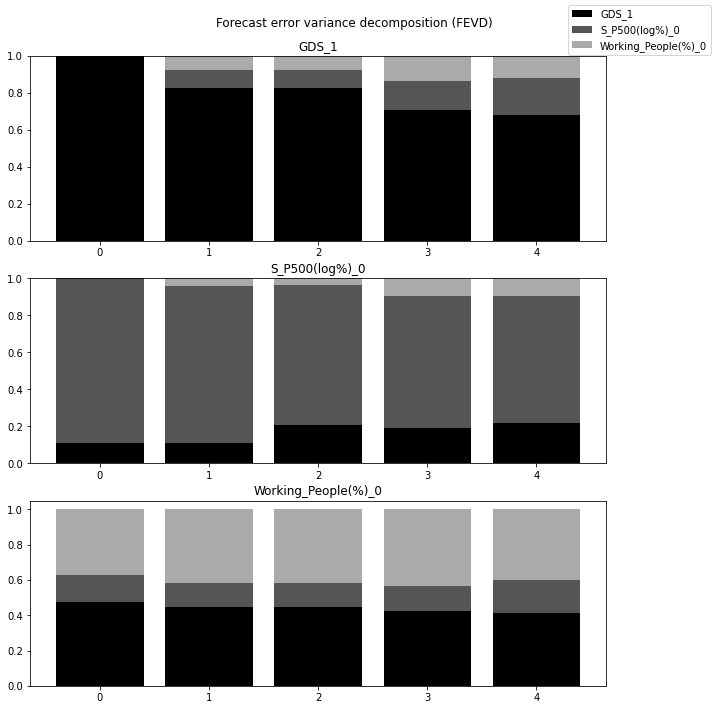

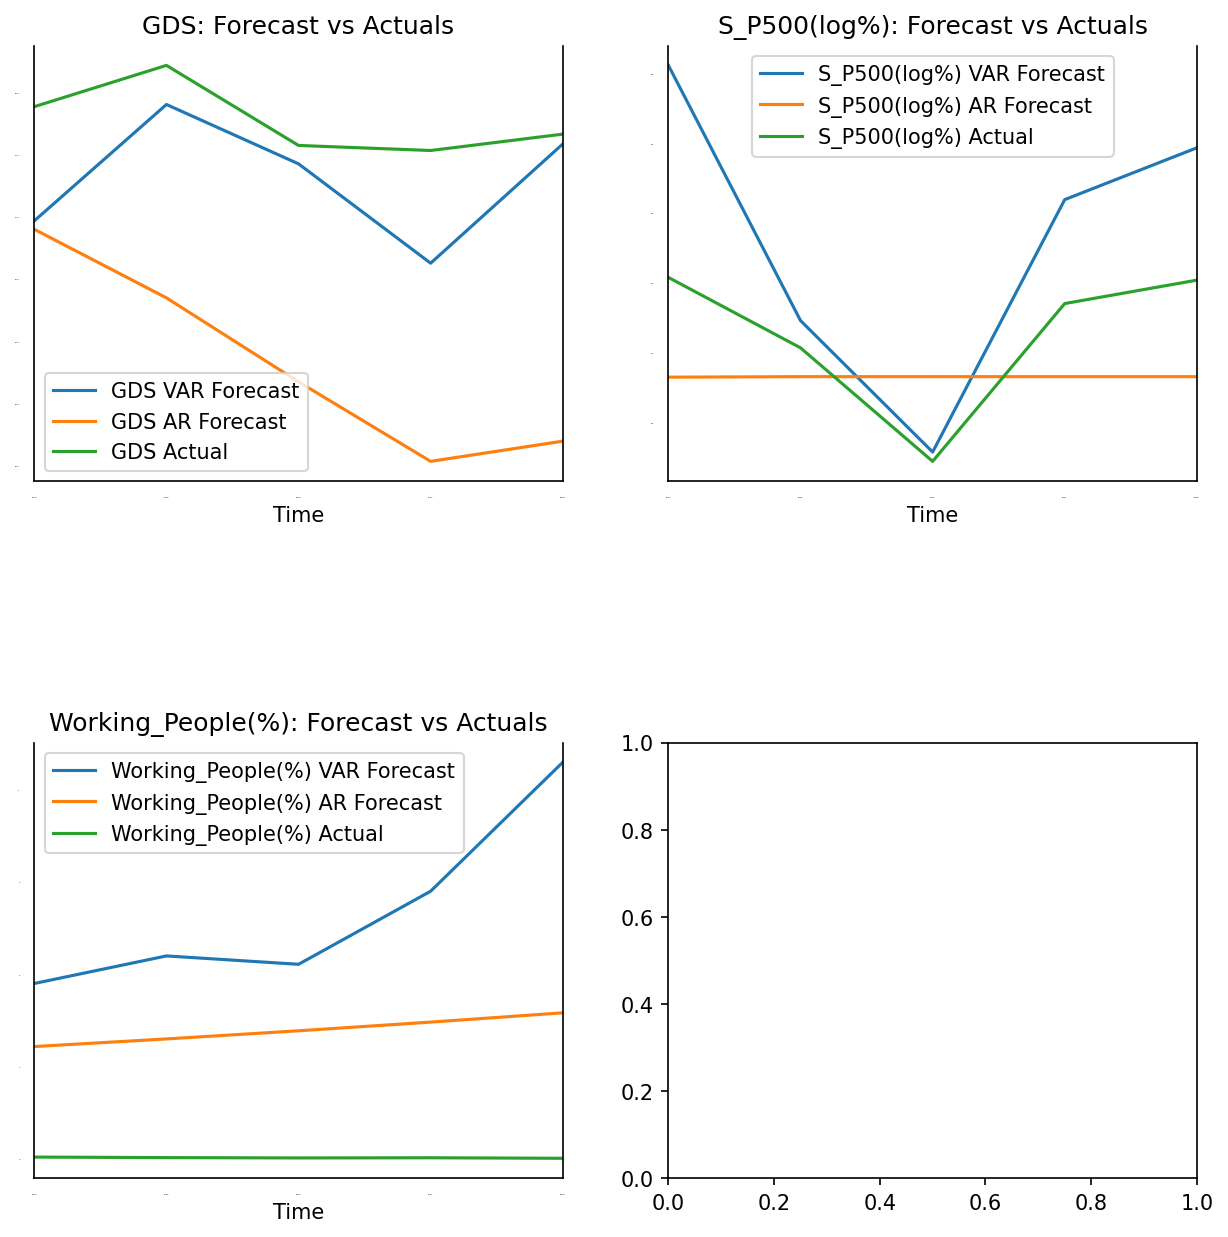

In [39]:
cointegration_test(USA[["GDS","Working_People(%)","S_P500"]].dropna())
VAR_AR_plot_evaluation(USA[["GDS","S_P500(log%)","Working_People(%)"]].dropna(),order=8)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
population(15-64,milion) ::  116.19    > 67.6367   =>   True
GDP_growth ::  61.69     > 46.5716   =>   True
GDS    ::  31.36     > 29.5147   =>   True
S_P500 ::  4.2       > 16.364    =>   False
Unemployment(%) ::  0.68      > 6.9406    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic      -1.407333
p-value                  0.578756
# lags used              2.000000
# observations          46.000000
Critical Value (1%)     -3.581258
Critical Value (5%)     -2.926785
Critical Value (10%)    -2.601541
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -0.137895
p-value                  0.945531
# lags used              1.000000
# observations          46.000000
Critical Value (1%)     -3.581258
Critical Value (5%)     -2.926785
Critical Value (10%)    -2.601541
Weak 

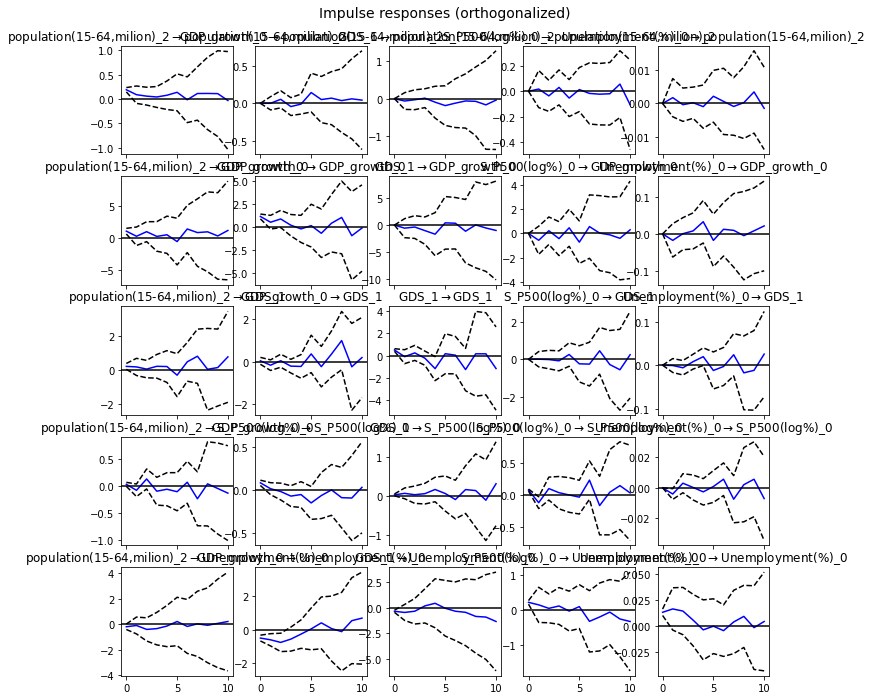

The function plots the Forecast Error Variance Decomposition
FEVD for population(15-64,milion)_2
     population(15-64,milion)_2  GDP_growth_0     GDS_1  S_P500(log%)_0  Unemployment(%)_0
0                      1.000000      0.000000  0.000000        0.000000           0.000000
1                      0.913230      0.000005  0.080163        0.006540           0.000061
2                      0.839533      0.049973  0.082700        0.027740           0.000054
3                      0.804054      0.076421  0.078909        0.040565           0.000051
4                      0.702900      0.060767  0.169836        0.066446           0.000051

FEVD for GDP_growth_0
     population(15-64,milion)_2  GDP_growth_0     GDS_1  S_P500(log%)_0  Unemployment(%)_0
0                      0.460438      0.539562  0.000000        0.000000           0.000000
1                      0.344424      0.456367  0.101200        0.097914           0.000095
2                      0.400649      0.434491  0.091736      

{'population(15-64,milion)_2': 1,
 'GDP_growth_0': 5,
 'GDS_1': 6,
 'S_P500(log%)_0': 1,
 'Unemployment(%)_0': 3}

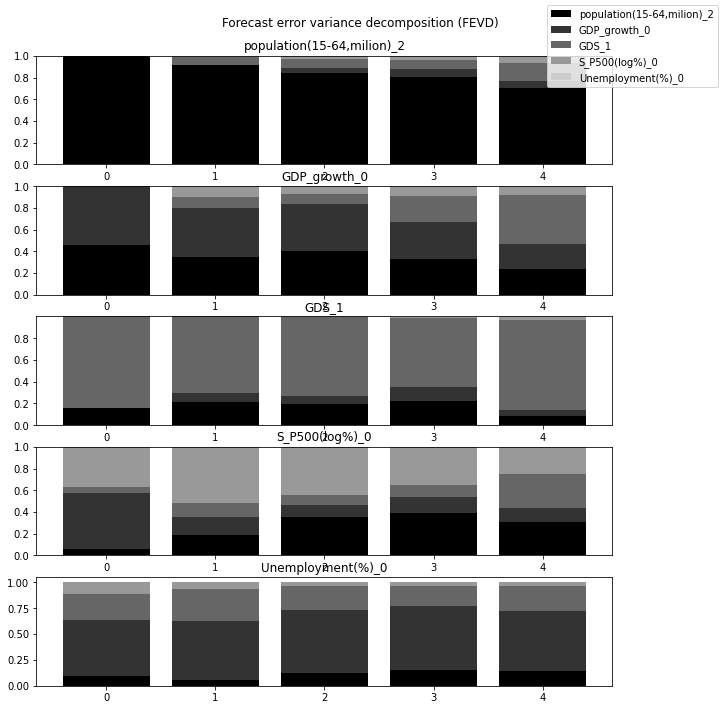

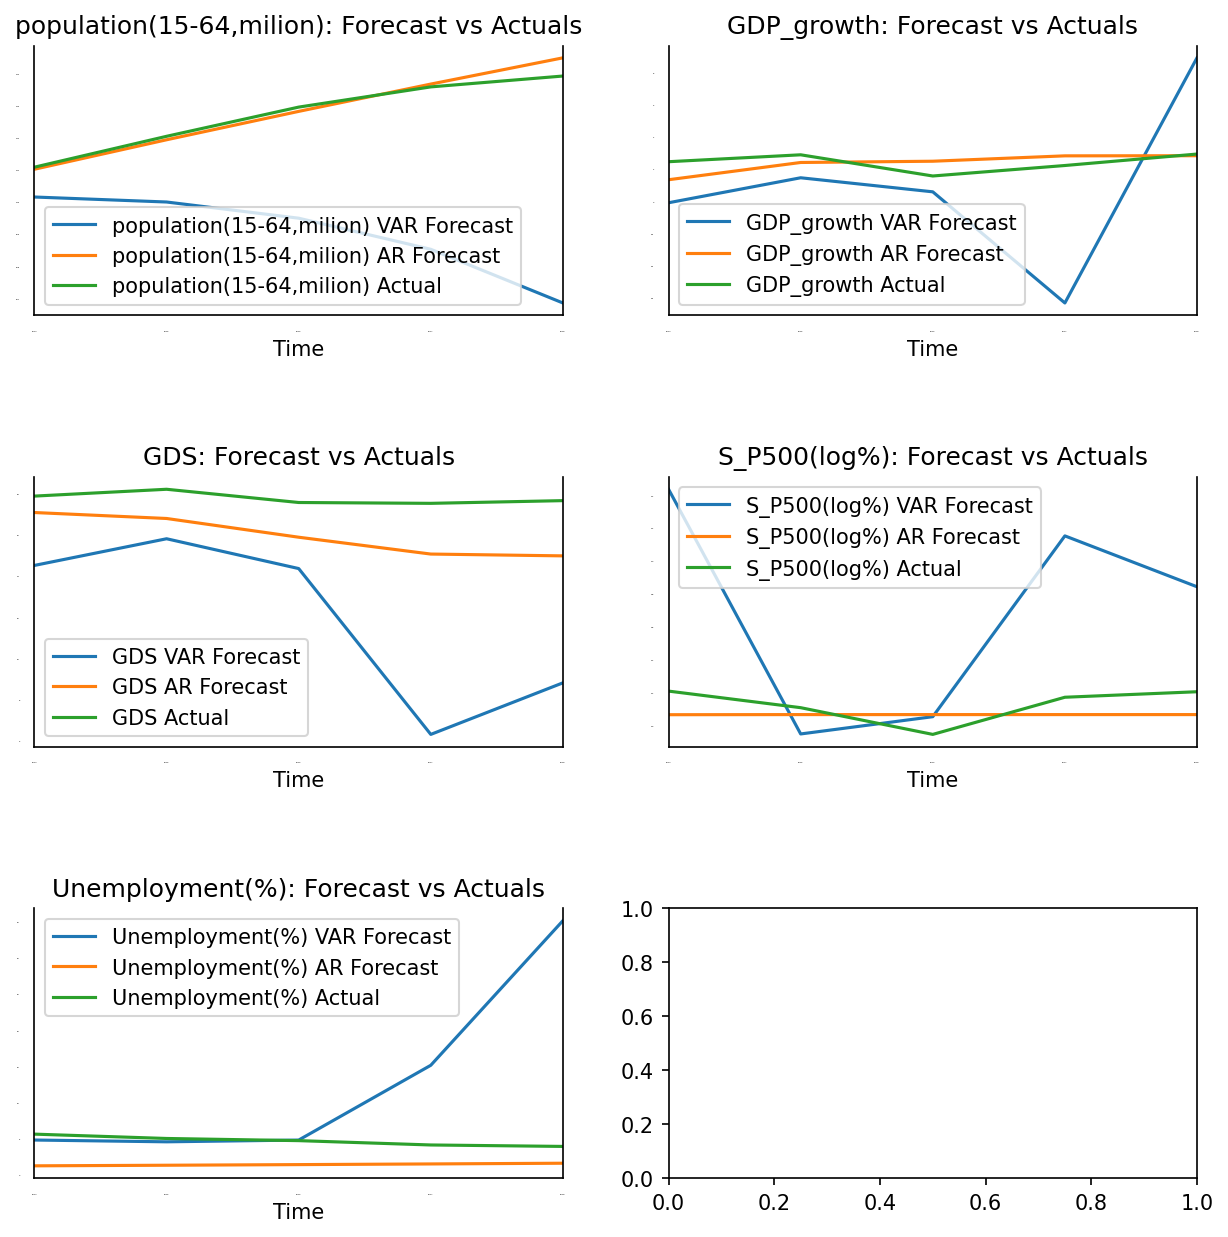

In [53]:
cointegration_test(USA[["population(15-64,milion)","GDP_growth","GDS","S_P500","Unemployment(%)"]].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation(USA[["population(15-64,milion)","GDP_growth","GDS","S_P500(log%)","Unemployment(%)"]].dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GCE    ::  75.04     > 46.5716   =>   True
TRADE  ::  33.84     > 29.5147   =>   True
GDP_growth ::  13.68     > 16.364    =>   False
S_P500 ::  0.07      > 6.9406    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic      -2.616175
p-value                  0.089700
# lags used              1.000000
# observations          47.000000
Critical Value (1%)     -3.577848
Critical Value (5%)     -2.925338
Critical Value (10%)    -2.600774
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -4.733731
p-value                  0.000073
# lags used              1.000000
# observations          46.000000
Critical Value (1%)     -3.581258
Critical Value (5%)     -2.926785
Critical Value (10%)    -2.601541
Strong evidence against the null hypothesis
Reject the null hypothesis
Data

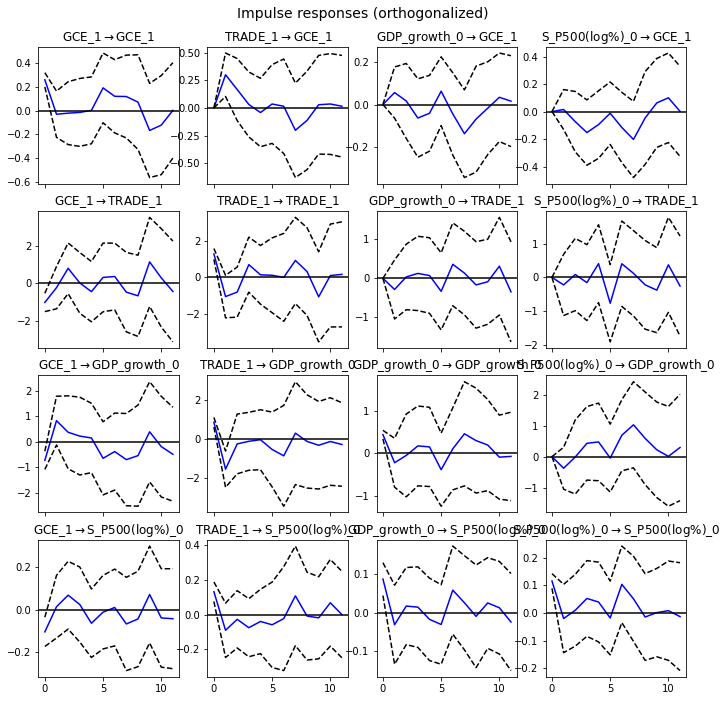

The function plots the Forecast Error Variance Decomposition
FEVD for GCE_1
        GCE_1   TRADE_1  GDP_growth_0  S_P500(log%)_0
0    1.000000  0.000000      0.000000        0.000000
1    0.424605  0.554403      0.019666        0.001326
2    0.353615  0.599864      0.017721        0.028800
3    0.309390  0.527705      0.033683        0.129223
4    0.293230  0.507276      0.039203        0.160291

FEVD for TRADE_1
        GCE_1   TRADE_1  GDP_growth_0  S_P500(log%)_0
0    0.372425  0.627575      0.000000        0.000000
1    0.262413  0.704184      0.020771        0.012633
2    0.318433  0.654825      0.015853        0.010890
3    0.289332  0.679495      0.017129        0.014044
4    0.301466  0.641466      0.016923        0.040145

FEVD for GDP_growth_0
        GCE_1   TRADE_1  GDP_growth_0  S_P500(log%)_0
0    0.364589  0.506244      0.129168        0.000000
1    0.258258  0.661074      0.050831        0.029838
2    0.275424  0.646597      0.049342        0.028637
3    0.270105  0.61

{'GCE_1': 6, 'TRADE_1': 4, 'GDP_growth_0': 6, 'S_P500(log%)_0': 1}

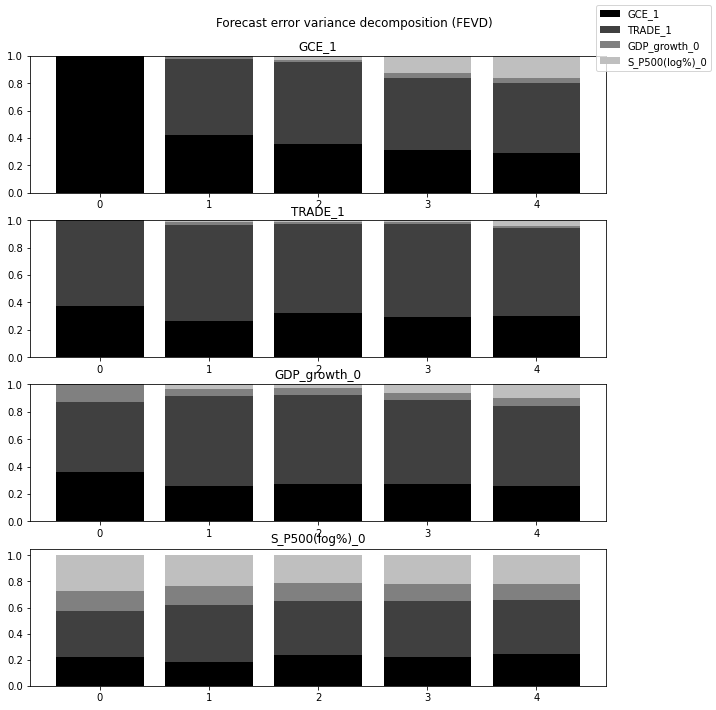

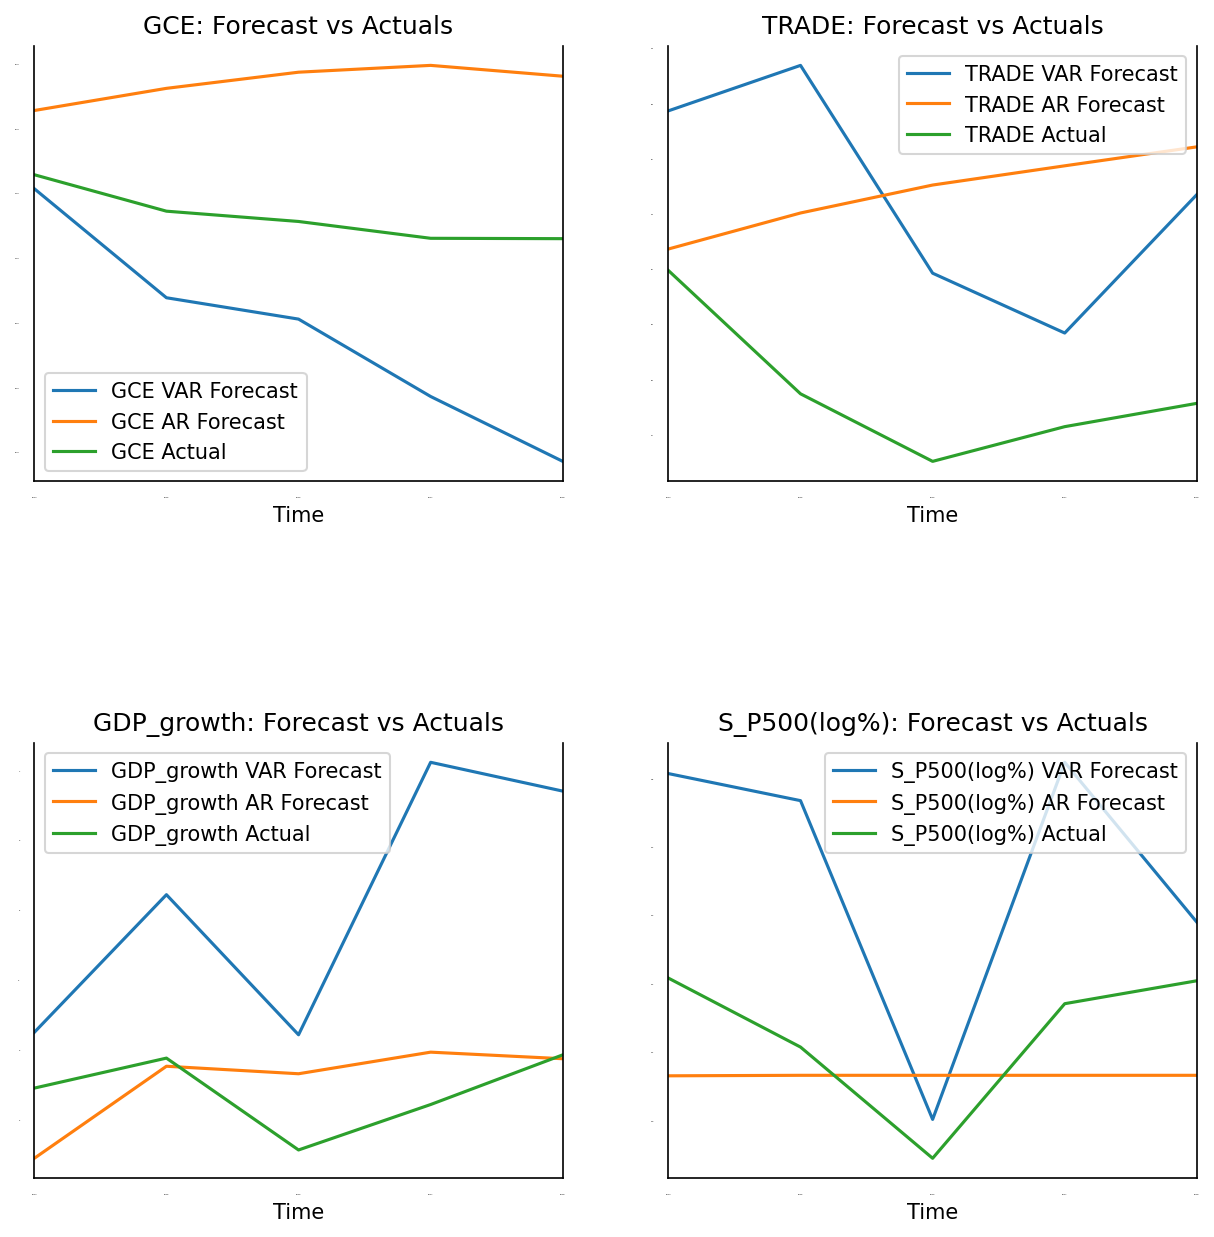

In [54]:
cointegration_test(USA[["GCE","TRADE","GDP_growth","S_P500"]].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation(USA[["GCE","TRADE","GDP_growth","S_P500(log%)"]].dropna(),order=8)

In [20]:
#ここから下で共和分している変数だけで予測できないかを見る．
print(USA.columns)
cointegration_test(USA[["S_P500","GDP_growth","GCE","GDS","Unemployment(%)","Working_People(million)"]].dropna())

Index(['S_P500', 'GDP_growth', 'GCE', 'GDS', 'GDPP', 'SMT', 'TRADE', 'RIR',
       'BCP', 'Turnover_Ratio', 'Broad_money', 'population(15-64,milion)',
       'Unemployment(%)', 'Working_People(million)', 'Working_People(%)',
       'S_P500(log%)'],
      dtype='object')
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
S_P500 ::  398.04    > 83.9383   =>   True
GDP_growth ::  256.67    > 60.0627   =>   True
GCE    ::  163.75    > 40.1749   =>   True
GDS    ::  91.94     > 24.2761   =>   True
Unemployment(%) ::  40.19     > 12.3212   =>   True
Working_People(million) ::  5.71      > 4.1296    =>   True


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
population(15-64,milion) ::  373.59    > 92.7136   =>   True
GDS    ::  231.4     > 67.6367   =>   True
GDP_growth ::  126.18    > 46.5716   =>   True
GCE    ::  67.75     > 29.5147   =>   True
Unemployment(%) ::  22.27     > 16.364    =>   True
S_P500 ::  10.1      > 6.9406    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Dec, 2020
Time:                     22:13:38
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    9.02817
Nobs:                     38.0000    HQIC:                   4.72510
Log likelihood:          -159.221    FPE:                    279.116
AIC:                      2.34854    Det(Omega_mle):         14.1402
--------------------------------------------------------------------
Results 

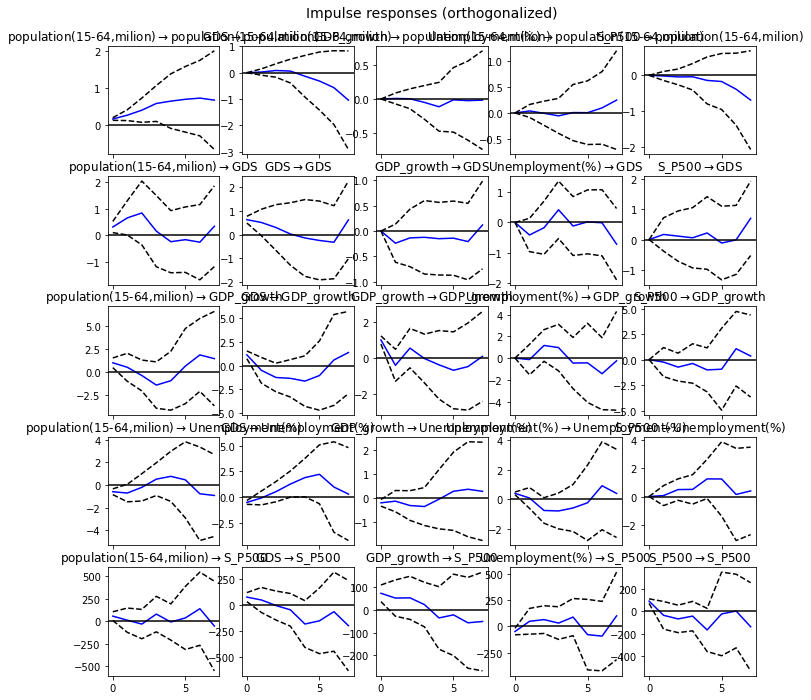

The function plots the Forecast Error Variance Decomposition
FEVD for population(15-64,milion)
     population(15-64,milion)       GDS  GDP_growth  Unemployment(%)    S_P500
0                    1.000000  0.000000    0.000000         0.000000  0.000000
1                    0.974334  0.006488    0.000614         0.014985  0.003578
2                    0.956864  0.028369    0.000259         0.005630  0.008878
3                    0.963513  0.018341    0.004188         0.007466  0.006491
4                    0.932173  0.026996    0.014283         0.004295  0.022253

FEVD for GDS
     population(15-64,milion)       GDS  GDP_growth  Unemployment(%)    S_P500
0                    0.195567  0.804433    0.000000         0.000000  0.000000
1                    0.363439  0.456183    0.040127         0.120151  0.020100
2                    0.534648  0.325033    0.033205         0.088684  0.018429
3                    0.497514  0.296947    0.036428         0.150870  0.018240
4                    0

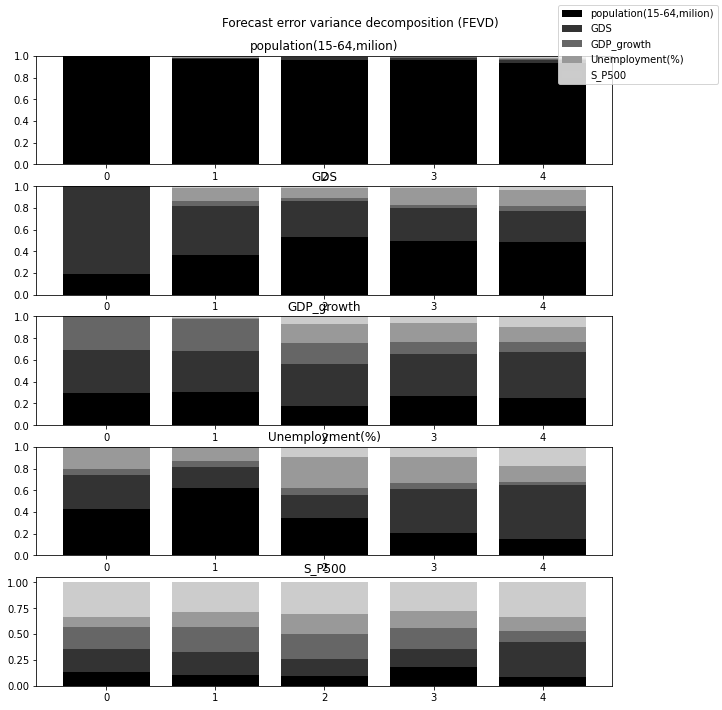

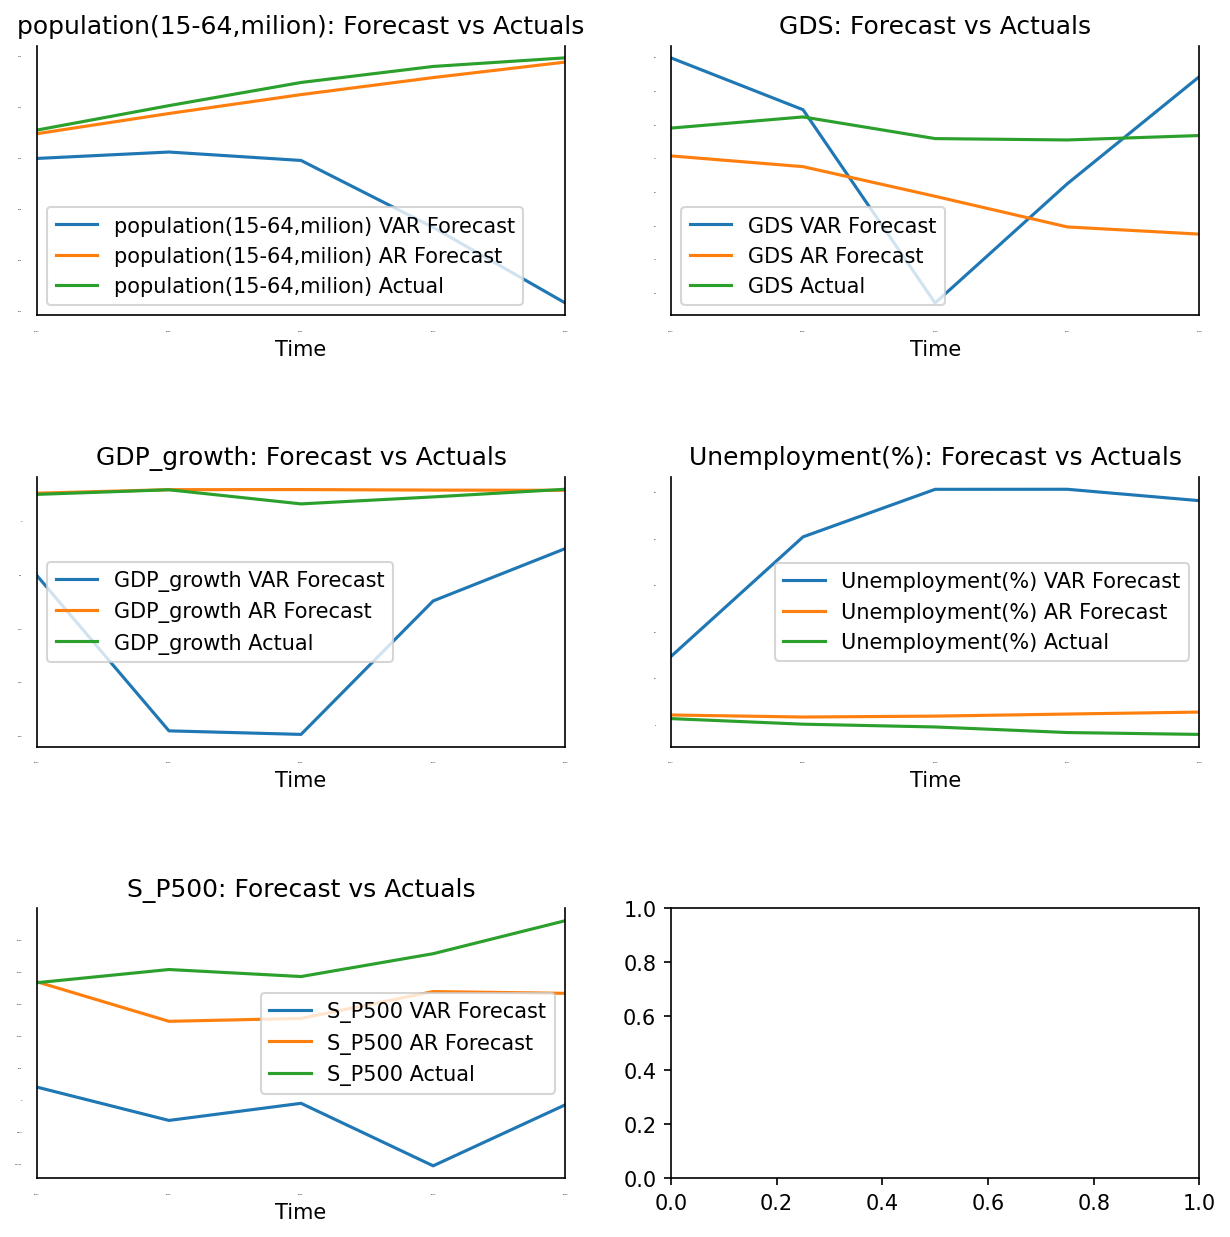

In [21]:
cointegration_test(USA[["population(15-64,milion)","GDS","GDP_growth","GCE","Unemployment(%)","S_P500"]].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation_nodiff(USA[["population(15-64,milion)","GDS","GDP_growth","Unemployment(%)","S_P500"]].dropna())

------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Dec, 2020
Time:                     15:08:22
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   0.713231
Nobs:                     38.0000    HQIC:                  -3.58984
Log likelihood:          -1.23678    FPE:                  0.0683366
AIC:                     -5.96640    Det(Omega_mle):      0.00346199
--------------------------------------------------------------------
Results for equation S_P500
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                          -34111.296080     45998.153120           -0.742           0.458
L1.S_P500                           0.528506         0.520943            

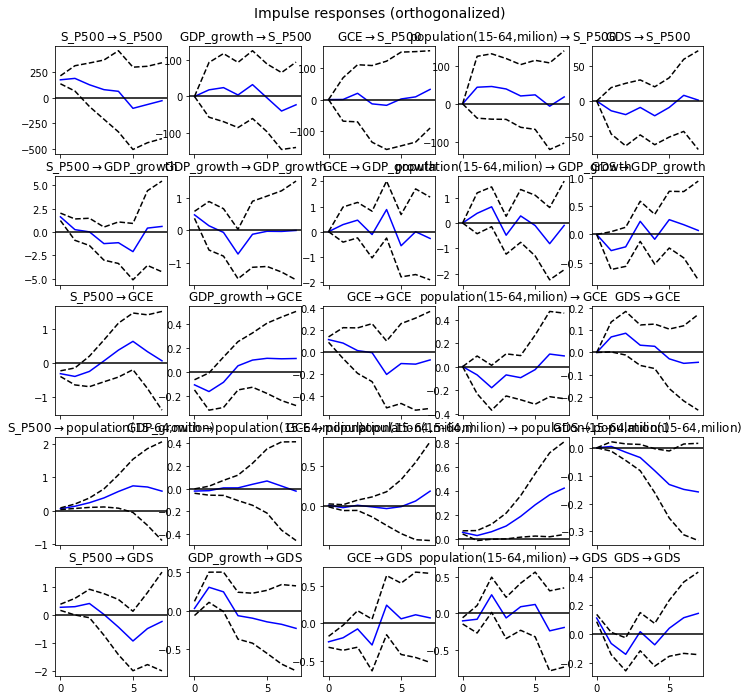

The function plots the Forecast Error Variance Decomposition
FEVD for S_P500
       S_P500  GDP_growth       GCE  population(15-64,milion)       GDS
0    1.000000    0.000000  0.000000                  0.000000  0.000000
1    0.963465    0.004984  0.000002                  0.028627  0.002922
2    0.930942    0.010833  0.004842                  0.046683  0.006699
3    0.917050    0.010120  0.006516                  0.059269  0.007045
4    0.898983    0.020251  0.009599                  0.060051  0.011115

FEVD for GDP_growth
       S_P500  GDP_growth       GCE  population(15-64,milion)       GDS
0    0.919418    0.080582  0.000000                  0.000000  0.000000
1    0.829437    0.077231  0.024189                  0.044565  0.024578
2    0.688871    0.065110  0.073036                  0.140594  0.032389
3    0.674026    0.125163  0.047610                  0.124547  0.028653
4    0.655476    0.094731  0.125913                  0.101742  0.022138

FEVD for GCE
       S_P500  GDP_growt

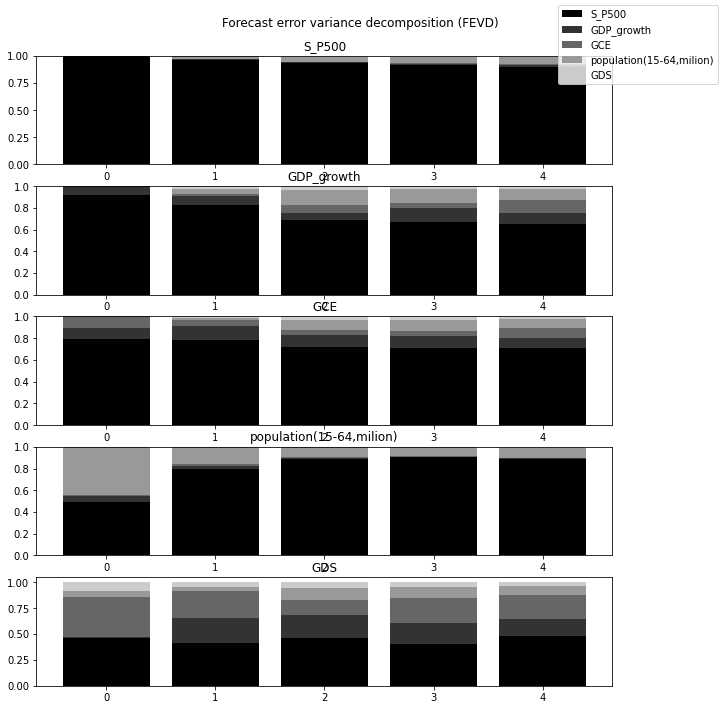

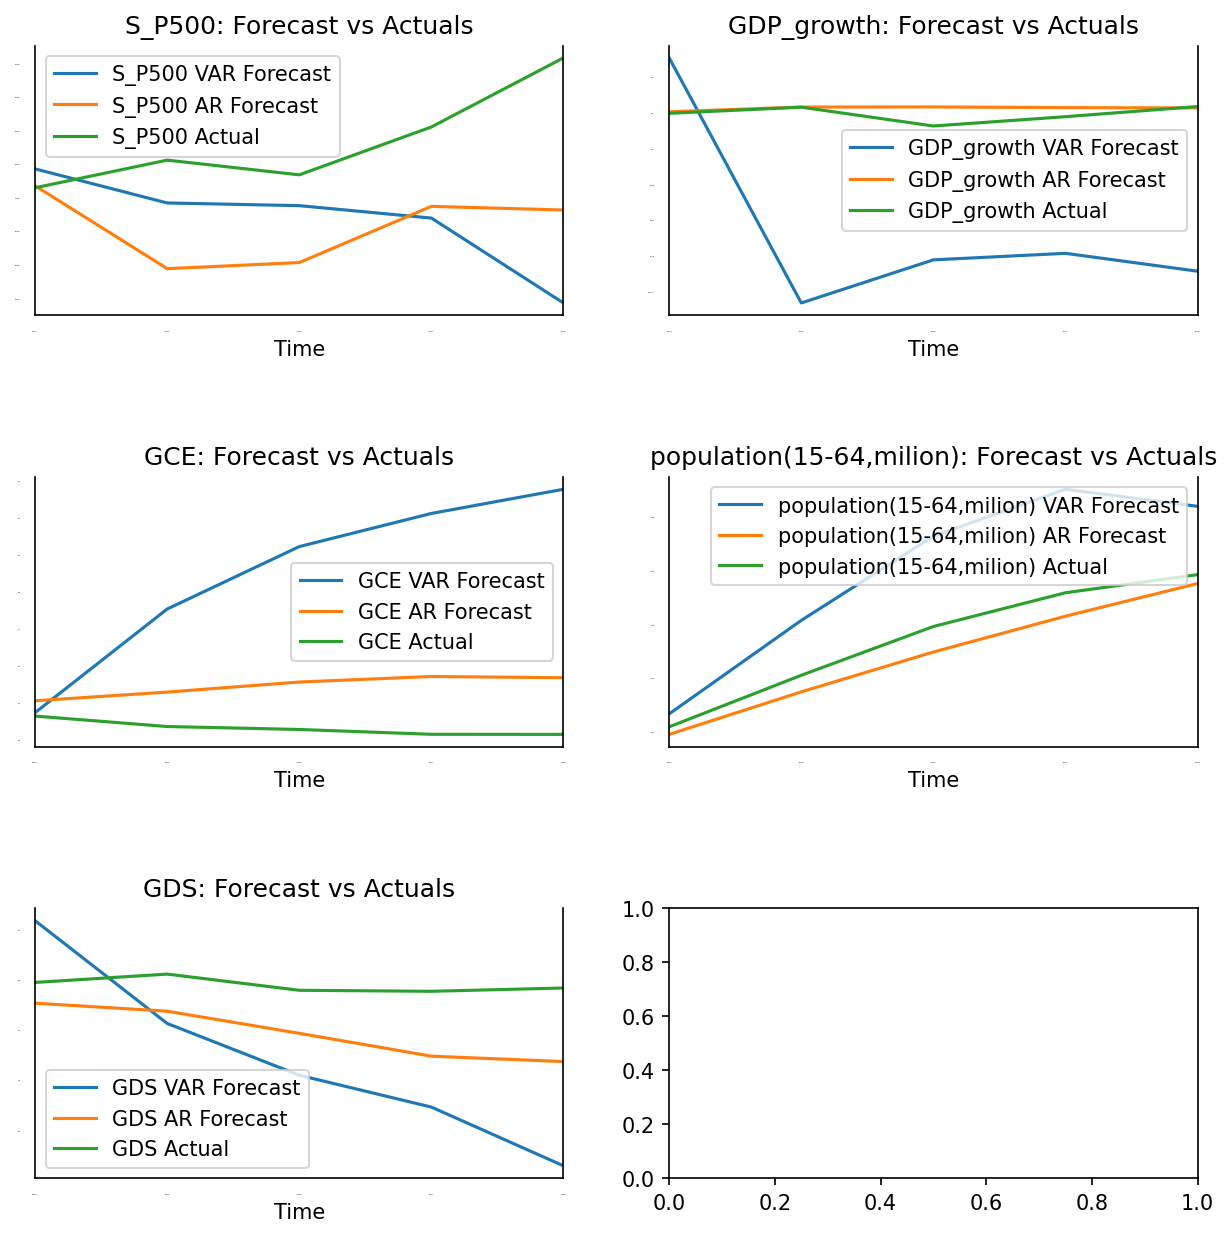

In [15]:
#稼働するかチェック
VAR_AR_plot_evaluation_nodiff(USA[["S_P500","GDP_growth","GCE","population(15-64,milion)","GDS"]].dropna())
## "SMT"を入れるとpositive definiteでなくなり，GDPPを含まない方がDurbin Watsonは低くでた．

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GDP_growth ::  165.64    > 67.6367   =>   True
GDS    ::  101.73    > 46.5716   =>   True
GCE    ::  54.97     > 29.5147   =>   True
Unemployment(%) ::  28.39     > 16.364    =>   True
S_P500 ::  7.57      > 6.9406    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Dec, 2020
Time:                     15:48:15
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    7.13481
Nobs:                     38.0000    HQIC:                   2.83175
Log likelihood:          -123.247    FPE:                    42.0253
AIC:                     0.455185    Det(Omega_mle):         2.12904
--------------------------------------------------------------------
Results for equation GDP_growth
                        coefficient  

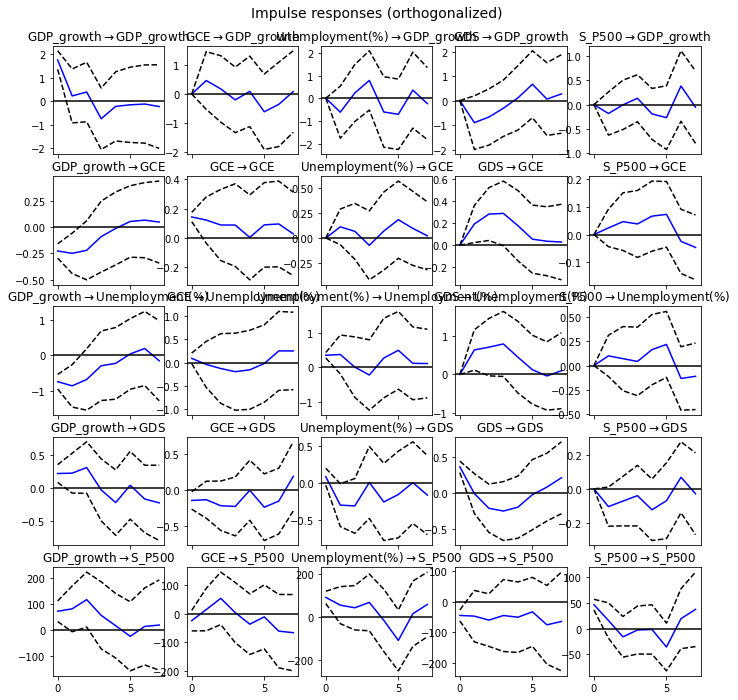

The function plots the Forecast Error Variance Decomposition
FEVD for GDP_growth
     GDP_growth       GCE  Unemployment(%)       GDS    S_P500
0      1.000000  0.000000         0.000000  0.000000  0.000000
1      0.687408  0.046588         0.082133  0.176543  0.007327
2      0.627214  0.046262         0.081345  0.238809  0.006369
3      0.584924  0.043099         0.158389  0.205836  0.007752
4      0.552398  0.041417         0.199868  0.193865  0.012452

FEVD for GCE
     GDP_growth       GCE  Unemployment(%)       GDS    S_P500
0      0.718211  0.281789         0.000000  0.000000  0.000000
1      0.570024  0.174469         0.063602  0.188978  0.002926
2      0.472756  0.123451         0.050137  0.345568  0.008088
3      0.378310  0.110681         0.050510  0.451040  0.009458
4      0.346654  0.101336         0.056334  0.477967  0.017709

FEVD for Unemployment(%)
     GDP_growth       GCE  Unemployment(%)       GDS    S_P500
0      0.806847  0.012663         0.180490  0.000000  0.0000

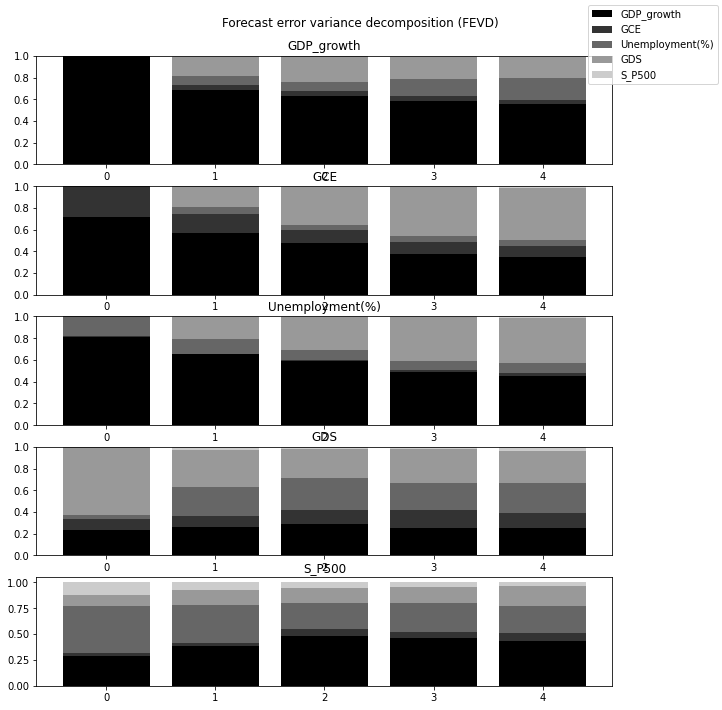

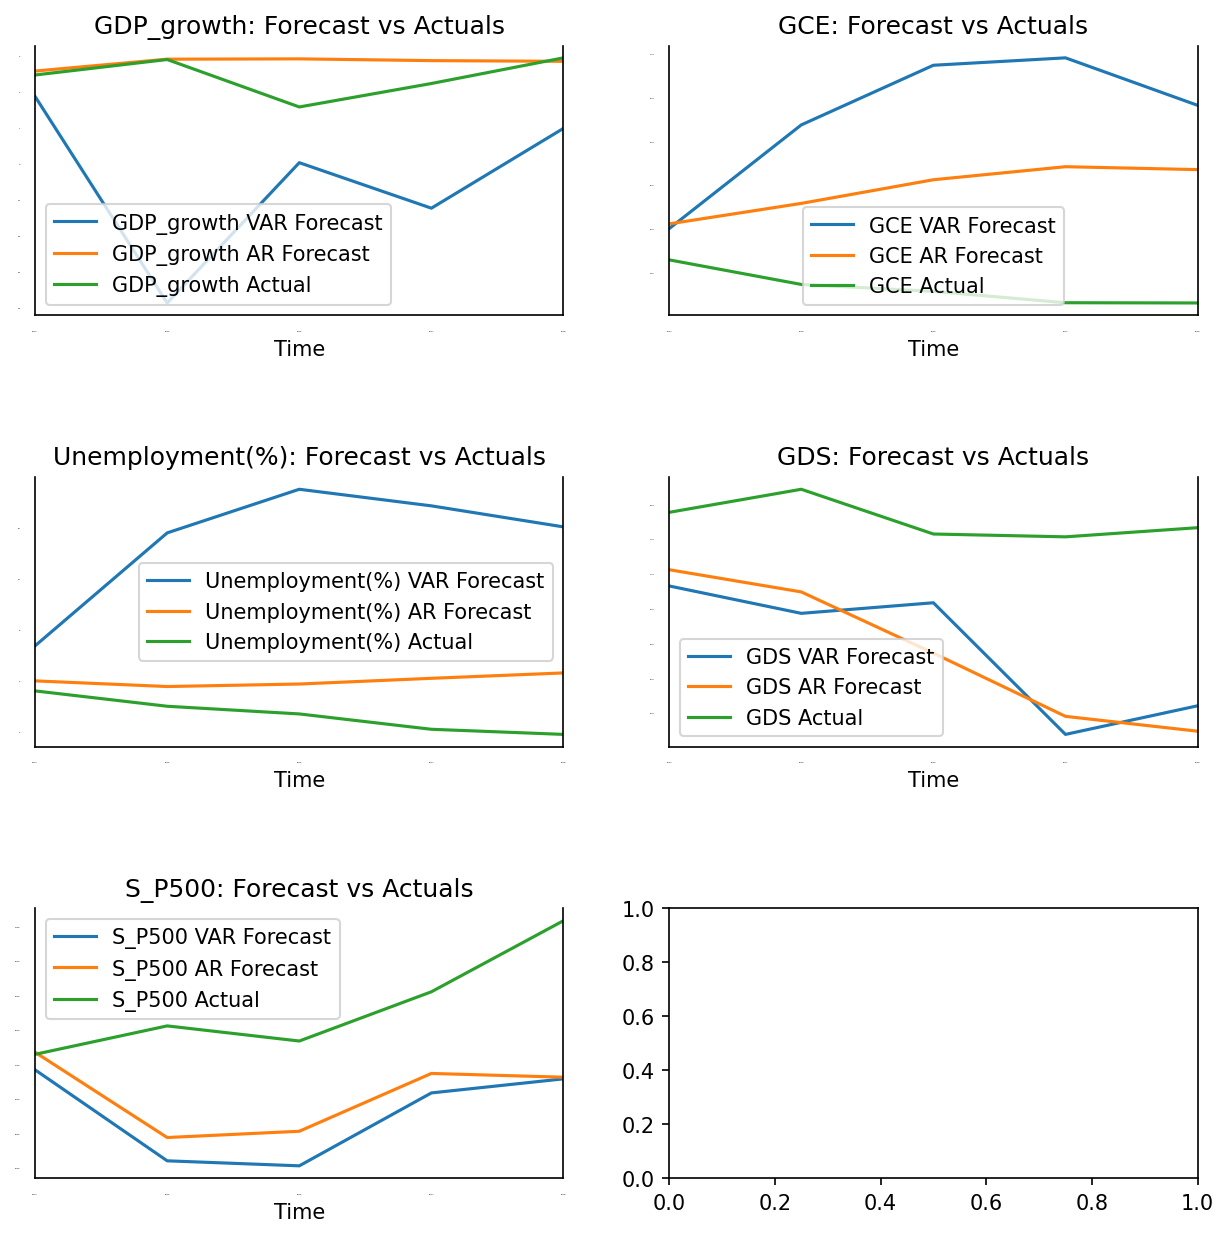

In [45]:
cointegration_test(USA[["GDP_growth","GCE","Unemployment(%)","GDS","S_P500"]].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation_nodiff(USA[["GDP_growth","GCE","Unemployment(%)","GDS","S_P500"]].dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GDS    ::  165.64    > 67.6367   =>   True
GDP_growth ::  101.73    > 46.5716   =>   True
GCE    ::  54.97     > 29.5147   =>   True
Unemployment(%) ::  28.39     > 16.364    =>   True
S_P500 ::  7.57      > 6.9406    =>   True
------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Dec, 2020
Time:                     15:45:27
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    7.13481
Nobs:                     38.0000    HQIC:                   2.83175
Log likelihood:          -123.247    FPE:                    42.0253
AIC:                     0.455185    Det(Omega_mle):         2.12904
--------------------------------------------------------------------
Results for equation GDS
                        coefficient       st

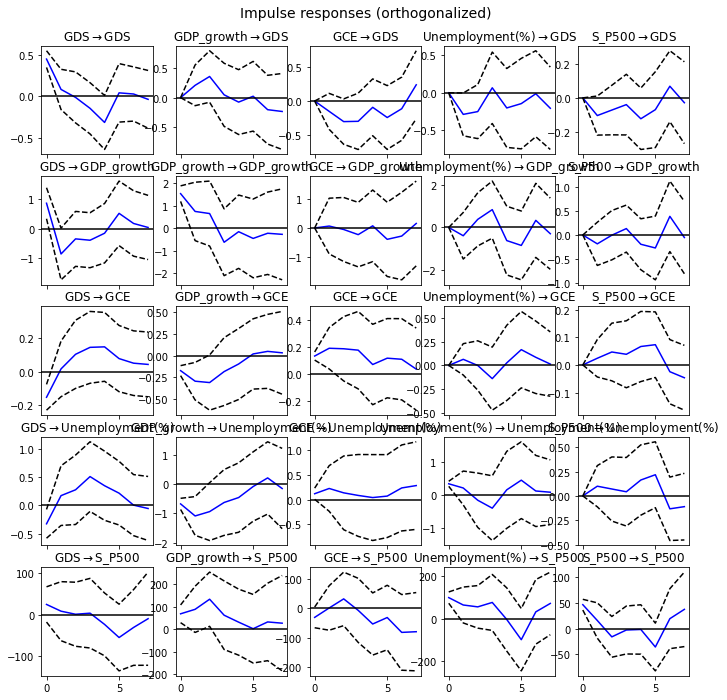

The function plots the Forecast Error Variance Decomposition
FEVD for GDS
          GDS  GDP_growth       GCE  Unemployment(%)    S_P500
0    1.000000    0.000000  0.000000         0.000000  0.000000
1    0.563178    0.119714  0.062124         0.225356  0.029629
2    0.315774    0.264912  0.172903         0.221938  0.024473
3    0.295236    0.227632  0.260419         0.193922  0.022791
4    0.347783    0.192709  0.222485         0.202240  0.034784

FEVD for GDP_growth
          GDS  GDP_growth       GCE  Unemployment(%)    S_P500
0    0.237111    0.762889  0.000000         0.000000  0.000000
1    0.322120    0.636685  0.000951         0.032917  0.007327
2    0.303043    0.633427  0.001344         0.055817  0.006369
3    0.266332    0.566379  0.009112         0.150425  0.007752
4    0.252164    0.532066  0.009280         0.194038  0.012452

FEVD for GCE
          GDS  GDP_growth       GCE  Unemployment(%)    S_P500
0    0.335426    0.419119  0.245455         0.000000  0.000000
1    0.12

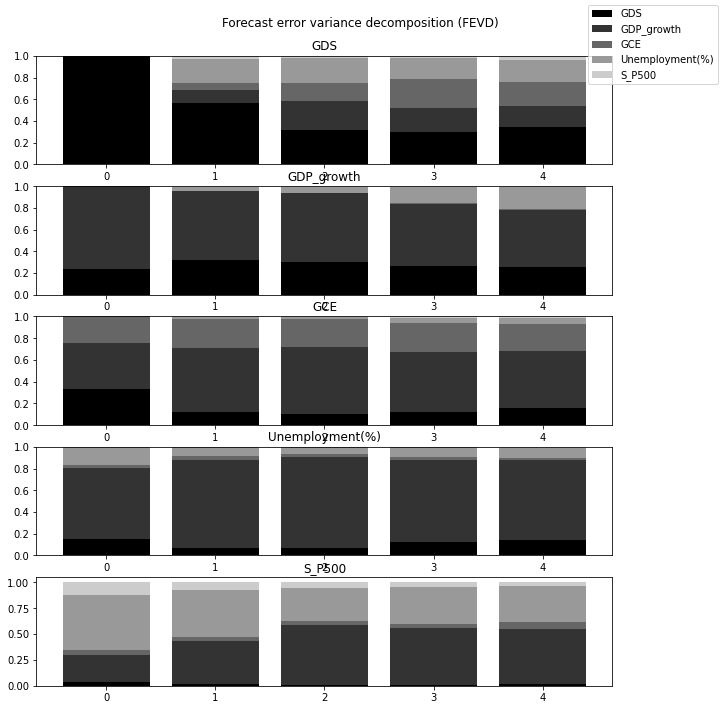

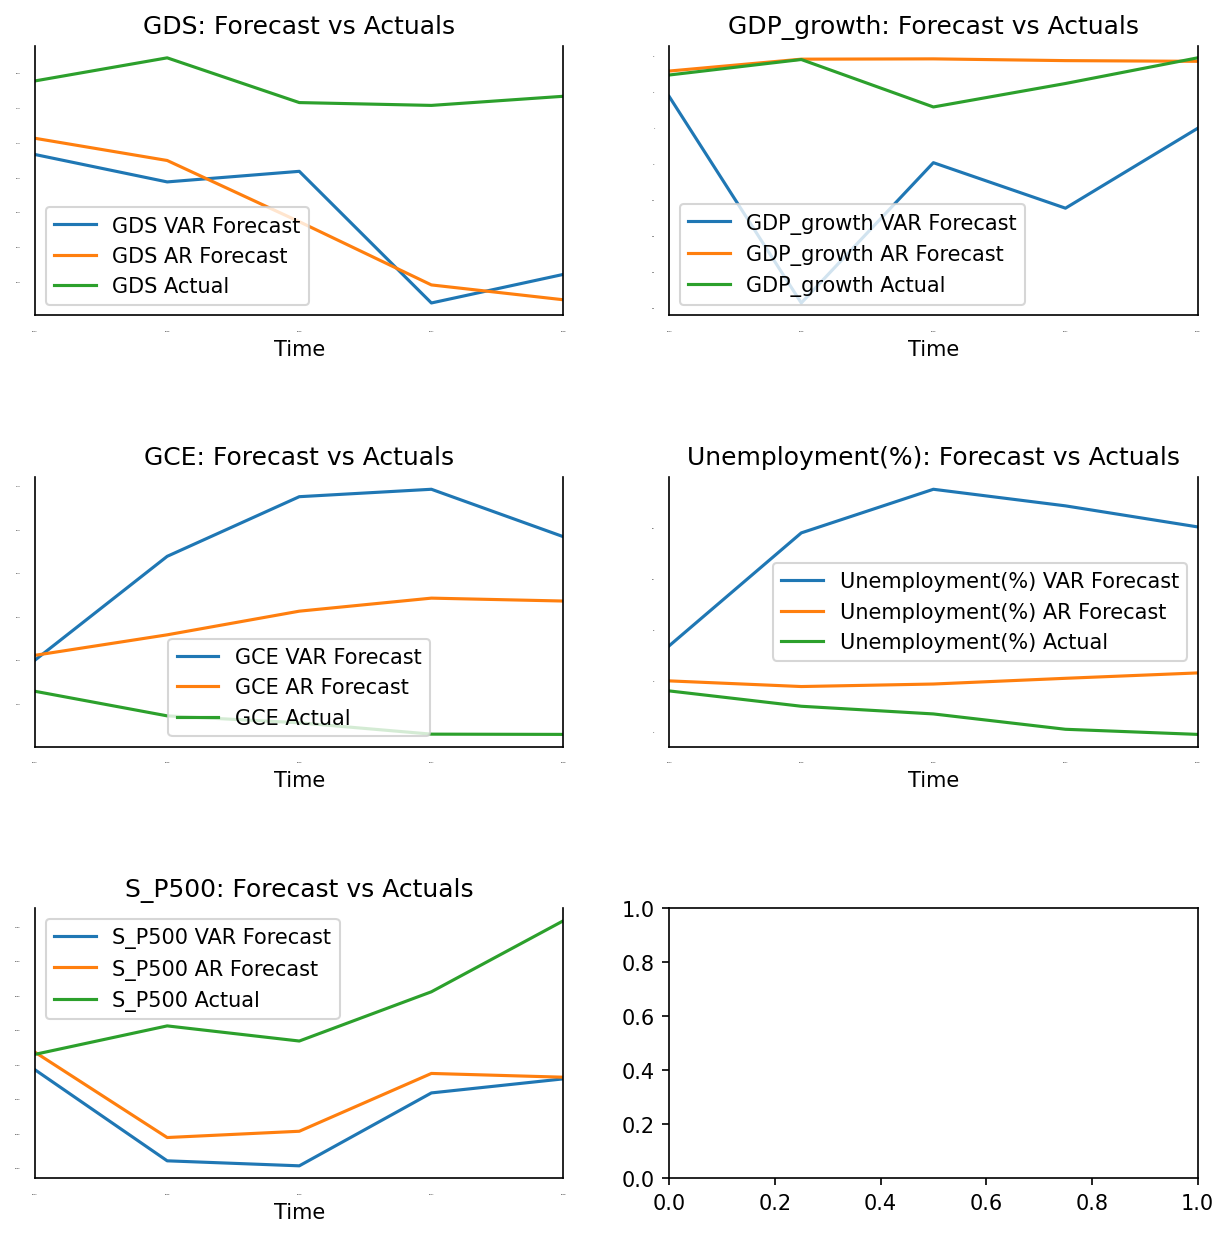

In [44]:
cointegration_test(USA[["GDS","GDP_growth","GCE","Unemployment(%)","S_P500"]].dropna(),alpha = 0.01)
VAR_AR_plot_evaluation_nodiff(USA[["GDS","GDP_growth","GCE","Unemployment(%)","S_P500"]].dropna())

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
population(15-64,milion) ::  116.19    > 67.6367   =>   True
GDP_growth ::  61.69     > 46.5716   =>   True
GDS    ::  31.36     > 29.5147   =>   True
S_P500 ::  4.2       > 16.364    =>   False
Unemployment(%) ::  0.68      > 6.9406    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic      -1.407333
p-value                  0.578756
# lags used              2.000000
# observations          46.000000
Critical Value (1%)     -3.581258
Critical Value (5%)     -2.926785
Critical Value (10%)    -2.601541
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -0.137895
p-value                  0.945531
# lags used              1.000000
# observations          46.000000
Critical Value (1%)     -3.581258
Critical Value (5%)     -2.926785
Critical Value (10%)    -2.601541
Weak 

LinAlgError: 5-th leading minor of the array is not positive definite

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
GCE    ::  75.04     > 46.5716   =>   True
TRADE  ::  33.84     > 29.5147   =>   True
GDP_growth ::  13.68     > 16.364    =>   False
S_P500 ::  0.07      > 6.9406    =>   False
Augumented Dickey-Fuller Test:
ADS test statistic      -2.616175
p-value                  0.089700
# lags used              1.000000
# observations          47.000000
Critical Value (1%)     -3.577848
Critical Value (5%)     -2.925338
Critical Value (10%)    -2.600774
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augumented Dickey-Fuller Test:
ADS test statistic      -4.733731
p-value                  0.000073
# lags used              1.000000
# observations          46.000000
Critical Value (1%)     -3.581258
Critical Value (5%)     -2.926785
Critical Value (10%)    -2.601541
Strong evidence against the null hypothesis
Reject the null hypothesis
Data

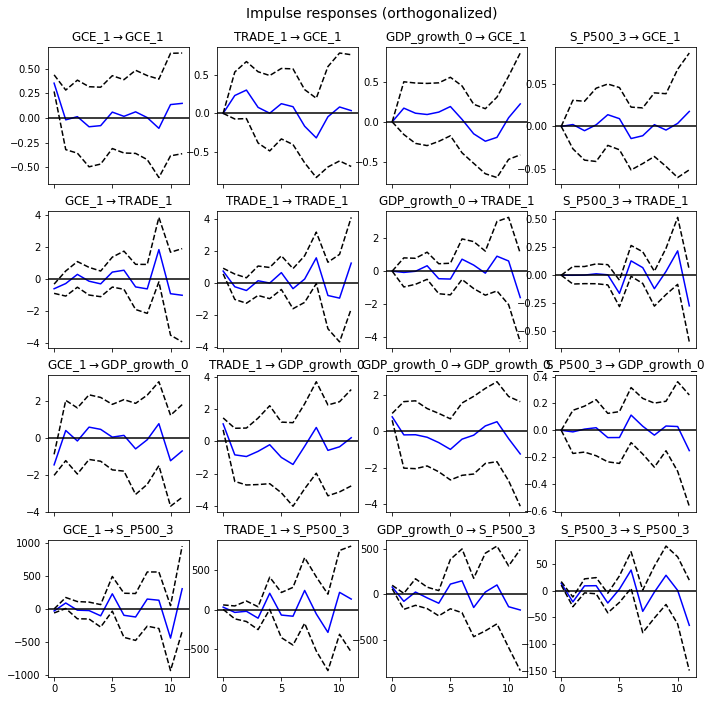

The function plots the Forecast Error Variance Decomposition
FEVD for GCE_1
        GCE_1   TRADE_1  GDP_growth_0  S_P500_3
0    1.000000  0.000000      0.000000  0.000000
1    0.603110  0.256256      0.140611  0.000023
2    0.404646  0.463557      0.131697  0.000100
3    0.401076  0.450632      0.148188  0.000104
4    0.394128  0.423954      0.181275  0.000644

FEVD for TRADE_1
        GCE_1   TRADE_1  GDP_growth_0  S_P500_3
0    0.398948  0.601052      0.000000  0.000000
1    0.419107  0.575272      0.005620  0.000000
2    0.385328  0.610271      0.004399  0.000001
3    0.360642  0.564402      0.074848  0.000107
4    0.350151  0.470536      0.179215  0.000098

FEVD for GDP_growth_0
        GCE_1   TRADE_1  GDP_growth_0  S_P500_3
0    0.536758  0.301850      0.161392  0.000000
1    0.470558  0.390434      0.138979  0.000029
2    0.397744  0.479902      0.122316  0.000038
3    0.400158  0.476932      0.122820  0.000090
4    0.394827  0.440049      0.164630  0.000494

FEVD for S_P500_3


{'GCE_1': 4, 'TRADE_1': 2, 'GDP_growth_0': 2, 'S_P500_3': 7}

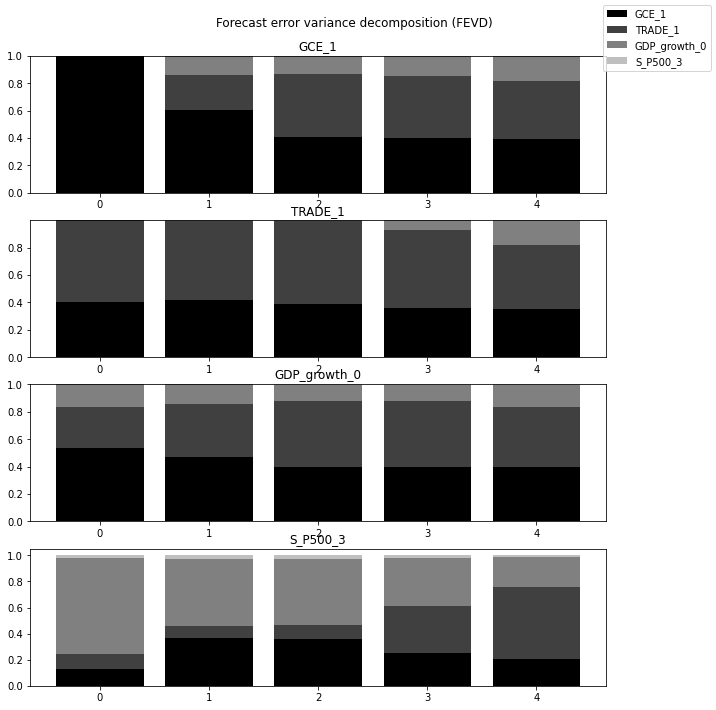

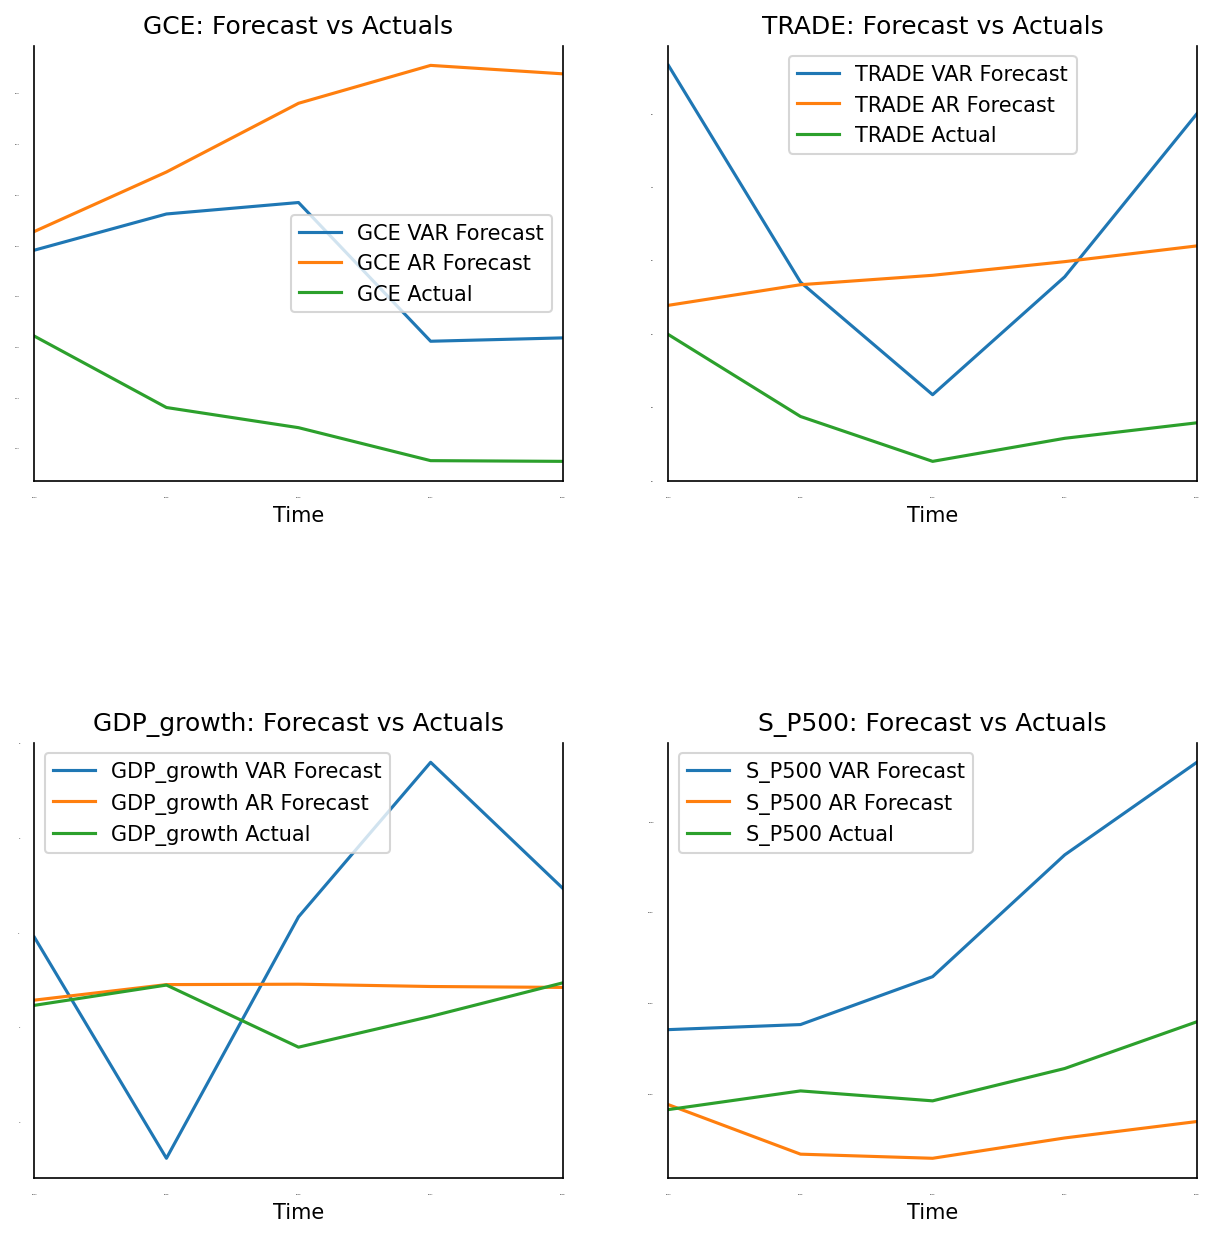